In [14]:
import sys
import calnet.calnet as cc
import calnet.dynamics as dyn
import numpy as np
from importlib import reload
import pdb
import matplotlib.pyplot as plt
import glob
import calnet.utils as utils
import pyute as ut
import size_contrast_analysis as sca
import opto_utils
import scipy.stats as sst
reload(cc)
reload(utils)

<module 'calnet.utils' from '/Users/dan/Documents/code/adesnal/calnet/utils.py'>

In [19]:
# fit_lbl = '201215b'#'201215b'
fit_lbl = '201215b'#'201227a'#
npyfile_baseline = np.load('../shared_data/calnet_data/dynamics/opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
# npyfile_vip_halo = np.load('../shared_data/calnet_data/dynamics/vip_halo_l4_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
# npyfile_vip_halo = np.load('../shared_data/calnet_data/dynamics/vip_halo_l23_as_l4_no_res_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
# npyfile_vip_chrimson = np.load('../shared_data/calnet_data/dynamics/vip_chrimson_l23_as_l4_no_res_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
npyfile_vip_halo = np.load('../shared_data/calnet_data/dynamics/vip_halo_l4_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
npyfile_vip_chrimson = np.load('../shared_data/calnet_data/dynamics/vip_chrimson_l4_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
npyfile_fix = np.load('../shared_data/calnet_data/dynamics/fix_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]


In [20]:
opto_levels = 1*np.linspace(0,1,11)
# opto_levels = np.array((0,0.5))
# opto_levels = np.array((-0.3,0,0.3))
nopto = opto_levels.shape[0]

In [21]:
YY_baseline = npyfile_baseline['YY_opto'][:,10:11,:,np.newaxis,:]
YY_halo = npyfile_vip_halo['YY_opto'][:,:,:,np.newaxis,:]
YY_chrimson = npyfile_vip_chrimson['YY_opto'][:,:,:,np.newaxis,:]
XX_halo = npyfile_vip_halo['XX_opto']#[:,:,:,np.newaxis,:]
XX_chrimson = npyfile_vip_chrimson['XX_opto']#[:,:,:,np.newaxis,:]
YY_fix = npyfile_fix['YY_opto']#[:,:,:,np.newaxis,:]
XX_fix = npyfile_fix['XX_opto']#[:,:,:,np.newaxis,:]

In [22]:
weights_files = glob.glob('../shared_data/calnet_data/weights/weights_%s/*.npy'%fit_lbl)
weights_files.sort()

reload(cc)
nwt = len(weights_files)
mdls = [None for iwt in range(nwt)]
losses = np.zeros((nwt,))
for iwt in range(nwt):
#     wtfile = 'weights_'+good_fits[iwt]+'.npy'
#     wtdict = np.load(wtbase+wtfile,allow_pickle=True)[()]
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    mdls[iwt] = cc.ModelOri(wtdict,nT=1)
    losses[iwt] = mdls[iwt].loss

In [23]:
iwt = 0
nQ,nS,nT = mdls[iwt].nQ,mdls[iwt].nS,mdls[iwt].nT
bltiles = np.zeros((nwt,nQ*nS*nT))
amps = np.ones((nwt,nQ*nS*nT))
for iwt in range(nwt):
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    if 'bl' in wtdict:
        bl = wtdict['bl']
        bltiles[iwt] = np.tile(bl,nS*nT)
    if 'amp' in wtdict:
        amp = wtdict['amp']
        amps[iwt] = amp

In [24]:
    low_loss = (losses<np.nanpercentile(losses,20))
    
    mdls = [mdl for (mdl,ll) in zip(mdls,low_loss) if ll]
    weights_files = [mdl for (mdl,ll) in zip(weights_files,low_loss) if ll]
    
    YY_baseline = npyfile_baseline['YY_opto'][low_loss,10:11,:,np.newaxis,:]
    YY_halo = npyfile_vip_halo['YY_opto'][low_loss,:,:,np.newaxis,:]
    YY_chrimson = npyfile_vip_chrimson['YY_opto'][low_loss,:,:,np.newaxis,:]
    XX_halo = npyfile_vip_halo['XX_opto'][low_loss,np.newaxis,:,:]
    XX_chrimson = npyfile_vip_chrimson['XX_opto'][low_loss,np.newaxis,:,:]
    YY_fix = npyfile_fix['YY_opto'][low_loss]
    XX_fix = npyfile_fix['XX_opto'][low_loss]

    losses = losses[low_loss]
    
    nwt = len(mdls)
    iwt = 0
    itype = 0

    nN = mdls[iwt].nN
    ntypes = mdls[iwt].nQ*mdls[iwt].nS*mdls[iwt].nT
    ninptypes = mdls[iwt].nP*mdls[iwt].nS*mdls[iwt].nT
    this_mdl,this_YY = mdls.copy(),YY_halo.copy()

    network_resp_halo = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
    network_resp_chrimson = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
    network_resp_baseline = np.zeros((nwt,1,nN,ntypes))
    inp_halo = np.zeros((nwt,1,nN,ninptypes))
    inp_chrimson = np.zeros((nwt,1,nN,ninptypes))
    inp_baseline = np.zeros((nwt,1,nN,ninptypes))
    cell_intrinsic_resp = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
    for iwt in range(nwt):
        network_resp_halo[iwt] = np.nanmean(YY_halo[iwt],2) # time avg
        network_resp_chrimson[iwt] = np.nanmean(YY_chrimson[iwt],2) # time avg
        network_resp_baseline[iwt] = np.nanmean(YY_baseline[iwt],2)
        
        inp_halo[iwt] = XX_halo[iwt]
        inp_chrimson[iwt] = XX_chrimson[iwt]
        inp_baseline[iwt] = mdls[iwt].XX[np.newaxis]

        for ilevel in range(opto_levels.shape[0]):
            cell_intrinsic_resp[iwt,ilevel] = this_mdl[iwt].compute_f_(opto_levels[ilevel]+this_mdl[iwt].Eta,this_mdl[iwt].Xi,this_mdl[iwt].s02)
            

In [25]:
opto_diff = np.sum(np.abs(network_resp_baseline[:,:,:,0]-network_resp_chrimson[:,:,:,0]),axis=2)

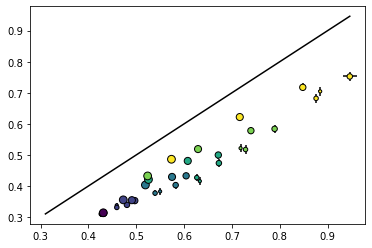

In [26]:
plt.figure()
sca.scatter_size_contrast_errorbar(YY_fix[:,4,:,0,0],YY_fix[:,2,:,0,0],nsize=6,ncontrast=6)

In [27]:
def compute_slope_intercept_res(xdata,ydata):
    xdata_norm = xdata/xdata.mean()[np.newaxis,np.newaxis]
    ydata_norm = ydata/xdata.mean()[np.newaxis,np.newaxis]
    slope, intercept, r_value, p_value, std_err = sst.linregress(xdata_norm.flatten(), (ydata_norm-xdata_norm).flatten())
    pred = slope*xdata_norm + intercept
    actual = (ydata_norm-xdata_norm)
    residual = actual - pred
    return slope,intercept,residual

In [28]:
slope,intercept,res = [[None for idir in range(2)] for _ in range(3)]
xdata = network_resp_halo[:,:,:,0].reshape((-1,nopto,6,6))
ydata = network_resp_chrimson[:,:,:,0].reshape((-1,nopto,6,6))
zdata = network_resp_baseline[:,:,:,0].reshape((-1,1,6,6))
ilight_resmax = [None for idir in range(2)]
for idir in range(2):
    slope[idir] = np.zeros(ydata.shape[:2])
    intercept[idir] = np.zeros(ydata.shape[:2])
    res[idir] = np.zeros(ydata.shape)
    for ifit in range(ydata.shape[0]):
        for iopto in range(ydata.shape[1]):
            if idir==0:
                slope[idir][ifit,iopto],intercept[idir][ifit,iopto],this_res = compute_slope_intercept_res(zdata[ifit,0],xdata[ifit,iopto])
            if idir==1:
                slope[idir][ifit,iopto],intercept[idir][ifit,iopto],this_res = compute_slope_intercept_res(zdata[ifit,0],ydata[ifit,iopto])
            res[idir][ifit,iopto] = this_res.reshape((6,6))
    ilight_resmax[idir] = np.argmax(np.abs(res[idir]).sum(2).sum(2),axis=1)

In [29]:
def compute_phis_couplings(YY_opto_tavg,mdls):
    nfiles = len(mdls)
    nopto = YY_opto_tavg.shape[1]
    phis = np.zeros((nfiles,nopto,6,6,nQ*nS*nT))
    couplings = np.zeros((nfiles,nopto,6,6,nQ*nS*nT,nQ*nS*nT))
    Xcouplings = np.zeros((nfiles,nopto,6,6,nP*nS*nT,nQ*nS*nT))
    for iwt,mdl in enumerate(mdls):
        bl,amp,WWmy,WWmx = [getattr(mdls[iwt],lbl) for lbl in ['bl','amp','WWmy','WWmx']]
        bltile = np.tile(bl,nS*nT)
        for ilight in range(nopto):
            this_YY = 1/amp[np.newaxis,:]*(YY_opto_tavg[iwt,ilight].reshape((nN,nQ*nS*nT)) - bltile[np.newaxis,:])
    #         this_YY = YY_opto_tavg[iwt,ilight].reshape((nN,nQ*nS*nT))
            phis[iwt,ilight] = mdls[iwt].fprimeXY(mdls[iwt].XX,this_YY).reshape((6,6,nQ*nS*nT))
        for istim in range(nN):
            iistim,jjstim = np.unravel_index(istim,(6,6))
    #         phis[iwt,iistim,jjstim] = calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+tiled_s02)
            for ilight in range(nopto):
                Phi = np.diag(phis[iwt,ilight,iistim,jjstim])
                couplings[iwt,ilight,iistim,jjstim] = Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
                Xcouplings[iwt,ilight,iistim,jjstim] = WWmx @ Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
    return phis,couplings,Xcouplings

In [30]:
nN,nP,nQ,nS,nT = mdls[iwt].nN,mdls[iwt].nP,mdls[iwt].nQ,mdls[iwt].nS,mdls[iwt].nT
phis_chrimson,couplings_chrimson,Xcouplings_chrimson = compute_phis_couplings(YY_chrimson,mdls)
phis_baseline,couplings_baseline,Xcouplings_baseline = compute_phis_couplings(YY_baseline,mdls)
phis_halo,couplings_halo,Xcouplings_halo = compute_phis_couplings(YY_halo,mdls)
phis_fix,couplings_fix,Xcouplings_fix = compute_phis_couplings(YY_fix,mdls)

In [31]:
ilight_drmax = [None for idir in range(2)]
i,j = 4,0
idir = 0
# ilight_drmax[idir] = np.argmax(couplings_halo[:,:,:,:,i,j].max(2).max(2)-couplings_halo[:,:,:,:,i,j].min(2).min(2),axis=1)
ilight_drmax[idir] = np.argmax(couplings_halo[:,:,:,0,i,j].max(2)-couplings_halo[:,:,:,-1,i,j].min(2),axis=1)
idir = 1
# ilight_drmax[idir] = np.argmax(couplings_chrimson[:,:,:,:,i,j].max(2).max(2)-couplings_chrimson[:,:,:,:,i,j].min(2).min(2),axis=1)
ilight_drmax[idir] = np.argmax(couplings_chrimson[:,:,:,0,i,j].max(2)-couplings_chrimson[:,:,:,-1,i,j].min(2),axis=1)

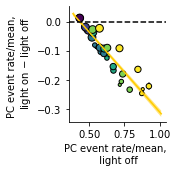

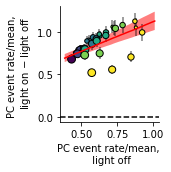

In [33]:
xdata = network_resp_halo[:,:,:,0].reshape((-1,nopto,6,6))
ydata = network_resp_chrimson[:,:,:,0].reshape((-1,nopto,6,6))
zdata = network_resp_baseline[:,:,:,0].reshape((-1,1,6,6))
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10)
fignames = ['figures/vip_halo_pc_sim_w_l4.jpg','figures/vip_chrimson_pc_sim_w_l4.jpg']
for idir,(opto_data,ilight,c,figname) in enumerate(zip([xdata,ydata],[5,5],[np.array((1,0.8,0)),np.array((1,0,0))],fignames)):
    this_data = np.concatenate((zdata[:,0:1,:,:],opto_data[np.arange(opto_data.shape[0]),ilight_drmax[idir],np.newaxis,:,:]),axis=1)
    plt.figure(figsize=(2.5,2.5))
    opto_utils.scatter_size_contrast_x_dx_errorbar(this_data[lkat].transpose((0,2,3,1)),opto_color=c)#,mn_plot=1,mx_plot=2)
    ut.erase_top_right()
    plt.tight_layout()
#     plt.savefig(figname,dpi=300)
# sca.scatter_size_contrast_errorbar(xdata,ydata)

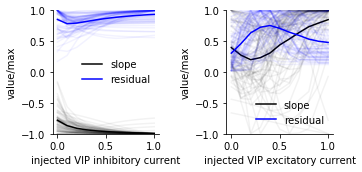

In [34]:
plt.figure(figsize=(5,2.5))
for idir in range(2):
    plt.subplot(1,2,idir+1)
#     data = np.abs(res[idir][lkat]/slope[idir][lkat,:,np.newaxis,np.newaxis]).sum(2).sum(2)
    data = slope[idir][lkat]
    plt.plot(opto_levels,(data/np.abs(data).max(1)[:,np.newaxis]).T,alpha=0.05,c='k')
    plt.plot(opto_levels,np.mean(data/np.abs(data).max(1)[:,np.newaxis],0),c='k',label='slope')
#     plt.plot((data).T,alpha=0.05,c='k')
#     plt.plot(np.mean(data,0),c='k')
    data = np.abs(res[idir][lkat]).sum(2).sum(2)
    plt.plot(opto_levels,(data/np.abs(data).max(1)[:,np.newaxis]).T,alpha=0.05,c='b')
    plt.plot(opto_levels,np.mean(data/np.abs(data).max(1)[:,np.newaxis],0),c='b',label='residual')
    plt.ylim((-1,1))
    ut.erase_top_right()
    if idir==0:
        plt.xlabel('injected VIP inhibitory current')
    else:
        plt.xlabel('injected VIP excitatory current')
    plt.ylabel('value/max')
    plt.legend(frameon=False)
plt.tight_layout()

In [35]:
opto_data[np.arange(opto_data.shape[0]),ilight_resmax[idir]].shape

(86, 6, 6)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-0.7211067494776001, 0.0)
0.08159148862451253


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(0.15641942135718412, 1.6898338498810442e-13)
0.05426891440050512


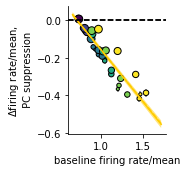

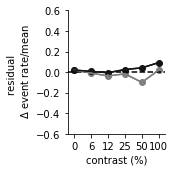

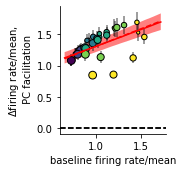

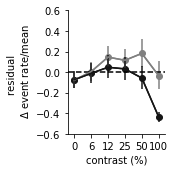

In [36]:
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10)
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10) & (YY_fix[:,1:3].max(1).max(1).max(1).max(1) < 10) & (couplings_fix[:,[1,2,4]].max(1).max(1).max(1).max(1).max(1) < 10)

residual = [None for idir in range(2)]

ibaseline = 0
ilow = 5
for ihigh in [5]:#range(10):
    itype = 0
    # ibaseline = 1
    # ilow = 0
    # ihigh = 2

    ucontrast = np.array((0,6,12,25,50,100))
    usize = np.array((5,8,13,25,36,60))
    this_nsize = len(usize)
    this_ncontrast = len(ucontrast)
    cfrac = np.linspace(1,0,this_nsize+1)[:-1]
    c_l23 = cfrac[:,np.newaxis]*np.array(((0.5,0.5,0.5)))

    import scipy.stats as sst
    import opto_utils
    reload(opto_utils)
    reload(sca)

    light_lbls = ['suppression','facilitation']

    cs = [np.array((1,0.8,0)),np.array((1,0,0))]

    ylims = [np.array((-0.58,0.02)),np.array((-0.02,0.55))]

    xdata = network_resp_baseline[lkat,ibaseline,:,itype].reshape((-1,6,6))
    xdata_norm = xdata/xdata.mean(1).mean(1)[:,np.newaxis,np.newaxis]
    for idir,(network_resp,ilight,light_lbl,c,ylim) in enumerate(zip([network_resp_halo,network_resp_chrimson],[ilow,ihigh],light_lbls,cs,ylims)):

        plt.figure(figsize=(2.5,2.5))
        ydata = network_resp[lkat,ilight,:,itype].reshape((-1,6,6))
        ydata = network_resp[lkat][np.arange(lkat.sum()),ilight_drmax[idir][lkat]][:,:,itype].reshape((-1,6,6))
        ydata_norm = ydata/xdata.mean(1).mean(1)[:,np.newaxis,np.newaxis]
        opto_utils.scatter_size_contrast_x_dx_errorbar(np.concatenate((xdata_norm[:,:,:,np.newaxis],ydata_norm[:,:,:,np.newaxis]),axis=-1),opto_color=c)
        plt.axhline(0,c='k',linestyle='dashed')
    #     ut.zero_origin('x')
        plt.xlabel('baseline firing rate/mean')
        plt.ylabel('$\Delta$firing rate/mean, \n PC %s'%light_lbl)
        slope, intercept, r_value, p_value, std_err = sst.linregress(xdata_norm.flatten(), (ydata_norm-xdata_norm).flatten())
        print((r_value,p_value))
        xs = np.array((xdata_norm.min(),xdata_norm.max()))
        plt.plot(xs,slope*xs+intercept,c=c,linestyle='dashed')
    #     plt.ylim(ylim)
        ut.erase_top_right()
        plt.tight_layout()
        plt.savefig('figures/delta_rate_vs_rate_vip_plus_l4_%s.jpg'%light_lbl,dpi=300)

        plt.figure(figsize=(2.5,2.5))
        pred = slope*xdata_norm + intercept
        actual = (ydata_norm-xdata_norm)
        residual[idir] = actual - pred
        these_sizes = [0,5]
        ut.plot_bootstrapped_errorbars_hillel(np.arange(6),residual[idir][:,these_sizes],colors=c_l23[these_sizes],pct=(16,84))
        plt.axhline(0,c='k',linestyle='dashed')
        plt.xticks(np.arange(this_ncontrast),ucontrast)
        ut.erase_top_right()
        plt.xlabel('contrast (%)')
        plt.ylabel('residual \n $\Delta$ event rate/mean')
        plt.ylim((-0.6,0.6))
        plt.tight_layout()
        plt.savefig('figures/residual_delta_rate_vs_contrast_vip_plus_l4_%s.eps'%light_lbl)
        
#         slope, intercept, r_value, p_value, std_err = sst.linregress(xdata_norm.flatten(), ydata_norm.flatten())
#         print((r_value,p_value))

# plt.figure(figsize=(2.5,2.5))
# xdata = network_resp[:,ibaseline,:,itype].reshape((-1,6,6))
# ydata = network_resp[:,ihigh,:,itype].reshape((-1,6,6))
# sca.scatter_size_contrast_errorbar(xdata,ydata-xdata,equality_line=False,square=False)
# plt.axhline(0,c='k',linestyle='dashed')
# ut.zero_origin('x')


In [1249]:
import sklearn
X = Xcouplings_baseline[lkat,0,:,:,:,:].reshape((lkat.sum()*nN,nP*nS*nT*nQ*nS*nT))
X = np.concatenate((X,couplings_baseline[lkat,0,:,:,:,:].reshape((lkat.sum()*nN,nQ*nS*nT*nQ*nS*nT))),axis=1)
y = residual[1].reshape((lkat.sum()*nN,))
# linreg = sklearn.linear_model.Ridge(alpha=10).fit(X,y)
# linreg = sklearn.linear_model.Lasso(alpha=0.03).fit(X,y)
linreg = sklearn.linear_model.Lasso(alpha=0.003).fit(X,y)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7037810584329236, tolerance: 0.1578066047982015
  positive)


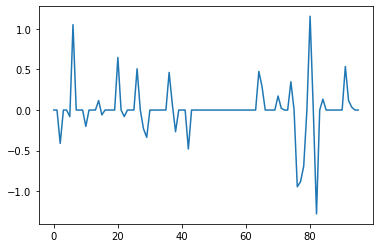

In [1250]:
plt.figure()
plt.plot(linreg.coef_)

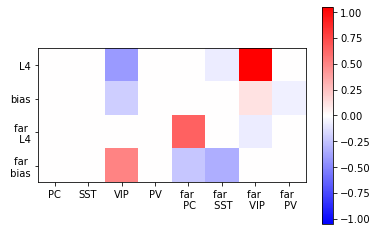

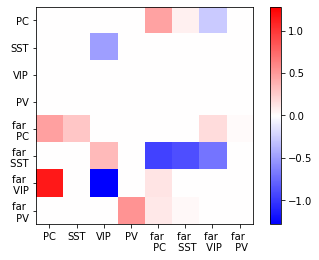

In [1251]:
xlbls = ['L4','bias','far \n L4','far \n bias']
ylbls = ['PC','SST','VIP','PV','far \n PC','far \n SST','far \n VIP','far \n PV']
plt.figure()
ut.imshow_hot_cold(linreg.coef_[:nP*nS*nT*nQ*nS*nT].reshape((nP*nS*nT,nQ*nS*nT)))
plt.xticks(np.arange(nQ*nS*nT),ylbls)
plt.yticks(np.arange(nP*nS*nT),xlbls)
plt.colorbar()
plt.ylim((3.5,-0.5))
plt.savefig('figures/vip_chrimson_residual_coefs_WWmx.jpg')

plt.figure()
ut.imshow_hot_cold(linreg.coef_[-nQ*nS*nT*nQ*nS*nT:].reshape((nQ*nS*nT,nQ*nS*nT)))
plt.xticks(np.arange(nQ*nS*nT),ylbls)
plt.yticks(np.arange(nQ*nS*nT),ylbls)
plt.colorbar()
plt.ylim((7.5,-0.5))
plt.savefig('figures/vip_chrimson_residual_coefs_WWmy.jpg')

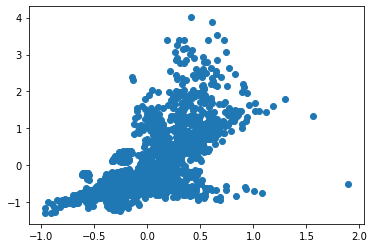

In [1202]:
plt.figure()
plt.scatter(linreg.predict(X),y)

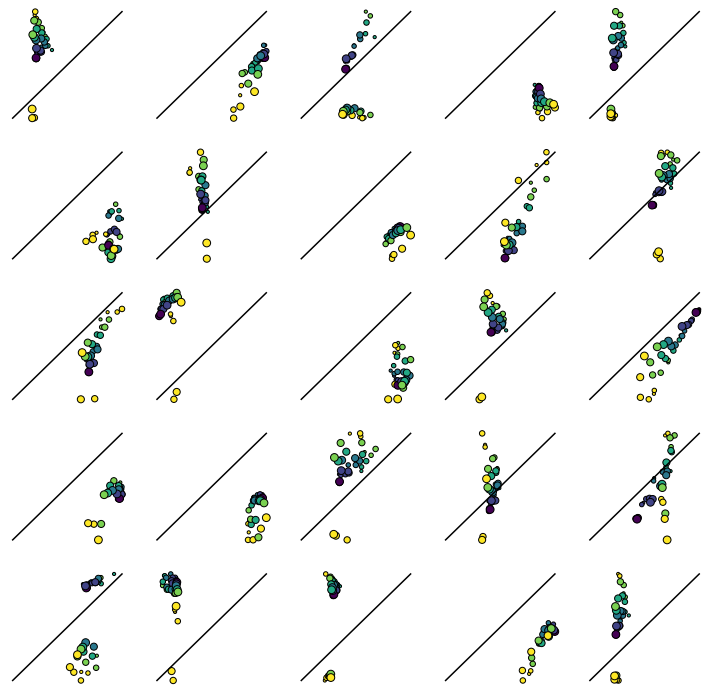

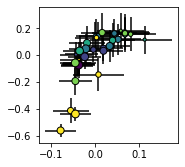

In [1216]:
yr = y.reshape((-1,6,6))
xr = linreg.predict(X).reshape((-1,6,6))
plt.figure(figsize=(12.5,12.5))
for iwt in range(25):
    plt.subplot(5,5,iwt+1)
    sca.scatter_size_contrast(xr[iwt],yr[iwt])
    plt.axis('off')
plt.figure(figsize=(2.5,2.5))
sca.scatter_size_contrast_errorbar(xr,yr,equality_line=False,square=False)

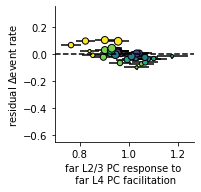

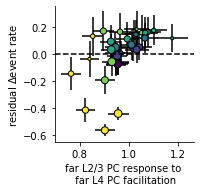

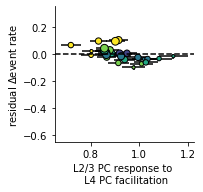

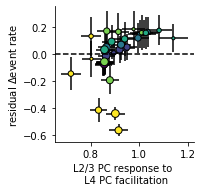

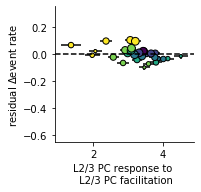

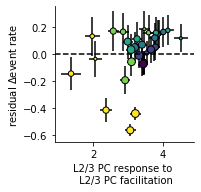

In [1255]:
i,j = 2,4
for idir in range(2):
    plt.figure(figsize=(2.5,2.5))
    sca.scatter_size_contrast_errorbar(Xcouplings_baseline[lkat,0,:,:,i,j],residual[idir][:,:,:],equality_line=False,square=False)
    plt.ylim((-0.65,0.35))
    plt.axhline(0,c='k',linestyle='dashed')
    ut.erase_top_right()
    plt.xlabel('far L2/3 PC response to \n far L4 PC facilitation')
    plt.ylabel('residual $\Delta$event rate')
    
    
i,j = 0,0
for idir in range(2):
    plt.figure(figsize=(2.5,2.5))
    sca.scatter_size_contrast_errorbar(Xcouplings_baseline[lkat,0,:,:,i,j],residual[idir][:,:,:],equality_line=False,square=False)
    plt.ylim((-0.65,0.35))
    plt.axhline(0,c='k',linestyle='dashed')
    ut.erase_top_right()
    plt.xlabel('L2/3 PC response to \n L4 PC facilitation')
    plt.ylabel('residual $\Delta$event rate')
    
i,j = 0,0
xdata = couplings_baseline[lkat,0,:,:,0,0] + couplings_baseline[lkat,0,:,:,4,0] + couplings_baseline[lkat,0,:,:,0,4] + couplings_baseline[lkat,0,:,:,4,4]
for idir in range(2):
    plt.figure(figsize=(2.5,2.5))
    sca.scatter_size_contrast_errorbar(xdata,residual[idir][:,:,:],equality_line=False,square=False)
    plt.ylim((-0.65,0.35))
    plt.axhline(0,c='k',linestyle='dashed')
    ut.erase_top_right()
    plt.xlabel('L2/3 PC response to \n L2/3 PC facilitation')
    plt.ylabel('residual $\Delta$event rate')

In [18]:
import calnet.utils
import sim_utils
nfiles = len(weights_files)
# Ts = np.zeros((nfiles,nQ))
iwt = 0
nN,nP,nQ,nS,nT = mdls[iwt].nN,mdls[iwt].nP,mdls[iwt].nQ,mdls[iwt].nS,mdls[iwt].nT
Ks = np.zeros((nfiles,nQ))
Wmys = np.zeros((nfiles,nQ,nQ))
Wmxs = np.zeros((nfiles,nP,nQ))
s02s = np.zeros((nfiles,nQ))
YYs = np.zeros((nfiles,6,6,nQ*nS*nT))
XXs = np.zeros((nfiles,6,6,nP*nS*nT))
Etas = np.zeros((nfiles,6,6,nQ*nS*nT))
# Eta1s = np.zeros((nfiles,6,6,nQ*nS*nT))
# Eta2s = np.zeros((nfiles,6,6,nQ*nS*nT))
h1s = np.zeros((nfiles,))
h2s = np.zeros((nfiles,))
bls = np.zeros((nfiles,nQ))
amps = np.zeros((nfiles,nQ*nS*nT))
losses = np.zeros((nfiles,))
couplings = np.zeros((nfiles,nopto,6,6,nQ*nS*nT,nQ*nS*nT))
phis = np.zeros((nfiles,nopto,6,6,nQ*nS*nT))
for iwt,weights_file in enumerate(weights_files):
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
#     Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h = Wstar_dict['as_list']
    try:
        Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h1,h2,bl = Wstar_dict['as_list']
        amp = np.ones((nQ*nS*nT,))
    except:
        try:
            Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h1,h2,bl,amp = Wstar_dict['as_list']
        except:
            Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,XX1,XX2,h1,h2,bl,amp = Wstar_dict['as_list']
    losses[iwt] = Wstar_dict['loss']
#     Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h1,h2,h3,Eta1,Eta2,Eta3 = Wstar_dict['as_list']
    WWmy = calnet.utils.gen_Weight_k_kappa_t(Wmy,K,kappa,T,nS=nS,nT=nT)
    WWmx = calnet.utils.gen_Weight_k_kappa_t(Wmx,K,kappa,T,nS=nS,nT=nT)
    tiled_s02 = np.tile(s02,nS*nT)
#     Ts[iwt] = T
    Ks[iwt] = K
    Wmys[iwt] = Wmy
    Wmxs[iwt] = Wmx
    s02s[iwt] = s02
    YY0 = sim_utils.f_miller_troyer(Eta,Xi**2+tiled_s02)
    this_YY = YY0
    YYs[iwt] = amp*YY0.reshape((6,6,nQ*nS*nT)) + np.tile(bl,nS*nT)[np.newaxis]
    XXs[iwt] = XX.reshape((6,6,nP*nS*nT))
    Etas[iwt] = Eta.reshape((6,6,nQ*nS*nT))
    h1s[iwt] = h1
    h2s[iwt] = h2
    bls[iwt] = bl
    amps[iwt] = amp
    bltile = np.tile(bls[iwt],nS*nT)
    for ilight in range(YY_opto_tavg.shape[1]):
#         this_YY = YY_opto_tavg[iwt,ilight].reshape((nN,nQ*nS*nT))
        phis[iwt,ilight] = mdls[iwt].fprimeXY(mdls[iwt].XX,this_YY).reshape((6,6,nQ*nS*nT))
    for istim in range(nN):
        iistim,jjstim = np.unravel_index(istim,(6,6))
#         phis[iwt,iistim,jjstim] = calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+tiled_s02)
        for ilight in range(nopto):
            Phi = np.diag(phis[iwt,ilight,iistim,jjstim])
            couplings[iwt,ilight,iistim,jjstim] = Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)

NameError: name 'YY_opto_tavg' is not defined

In [1046]:
mdls[iwt].fprimeXY(mdls[iwt].XX,this_YY).shape

(36, 8)

In [1050]:
ilight_halo = 5
ilight_chrimson = 5
ilight_off = 0

In [1052]:
len(mdls)

86

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


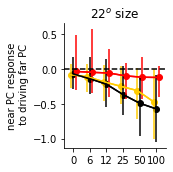

In [1054]:
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10)
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10) & (YY_fix[:,1:3].max(1).max(1).max(1).max(1) < 10) & (couplings_fix[:,[1,2,4]].max(1).max(1).max(1).max(1).max(1) < 10)


i,j = 4,0
isize = 3
for isize in [3]:
    plt.figure(figsize=(2.5,2.5))
    ucontrast = np.array((0,6,12,25,50,100))
    colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
    # these_couplings = np.concatenate((couplings_halo[lkat][:,[ilight_halo]][:,:,isize,:,i,j],\
    #     couplings_baseline[lkat][:,[ilight_off]][:,:,isize,:,i,j],\
    #     couplings_chrimson[lkat][:,[ilight_chrimson]][:,:,isize,:,i,j]),axis=1)
    these_couplings = np.concatenate((couplings_halo[lkat][np.arange(lkat.sum()),ilight_drmax[0][lkat],np.newaxis][:,:,isize,:,i,j],\
        couplings_baseline[lkat][:,[ilight_off]][:,:,isize,:,i,j],\
        couplings_chrimson[lkat][np.arange(lkat.sum()),ilight_drmax[1][lkat],np.newaxis][:,:,isize,:,i,j]),axis=1)
    ut.plot_pct_errorbars_hillel(np.arange(6),these_couplings,pct=(16,84),colors=colors,delta=0.1)
    ut.erase_top_right()
    plt.axhline(c='k',linestyle='dashed')
    plt.ylabel(r'near PC response'+'\n to driving far PC')
    plt.title('22$^o$ size')
    plt.xticks(np.arange(6),ucontrast)
    plt.tight_layout()
    plt.savefig('figures/far_pc_near_pc_coupling_sim_vip_opto.eps')


In [1088]:
couplings_halo[lkat][np.arange(lkat.sum()),ilight_drmax[0][lkat]].shape

(37, 6, 6, 8, 8)

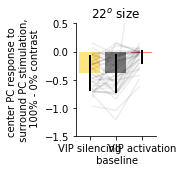

In [1092]:
i,j = 4,0
plt.figure(figsize=(2.5,2.5))
icontrast1,icontrast2 = 0,5
# arr1 = couplings_fix[lkat][:,4][:,isize,:,i,j]
# arr2 = couplings_fix[lkat][:,1][:,isize,:,i,j]
# arr3 = couplings_fix[lkat][:,2][:,isize,:,i,j]
arr1 = couplings_halo[lkat][np.arange(lkat.sum()),ilight_drmax[0][lkat]][:,isize,:,i,j]
arr2 = couplings_baseline[lkat][:,ilight_off][:,isize,:,i,j]
arr3 = couplings_chrimson[lkat][np.arange(lkat.sum()),ilight_drmax[1][lkat]][:,isize,:,i,j]
data1,data2,data3 = [arr[:,icontrast2] - arr[:,icontrast1] for arr in [arr1,arr2,arr3]]
datas = np.concatenate((data1[:,np.newaxis],data2[:,np.newaxis],data3[:,np.newaxis]),axis=1)
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
xticklabels = ['VIP silencing','\n baseline','VIP activation']
ut.plot_bars_with_lines(datas,colors=colors,xticklabels=xticklabels,errorstyle='pct',alpha=0.025)
plt.ylim((-1.5,0.5))
plt.ylabel('center PC response to \n surround PC stimulation, \n 100% - 0% contrast')
plt.title('22$^o$ size')
ut.erase_top_right()
plt.tight_layout()
plt.savefig('figures/far_pc_coupling_vip_halo_chrimson_dynamic_range_bars.jpg',dpi=300)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<Figure size 180x180 with 0 Axes>

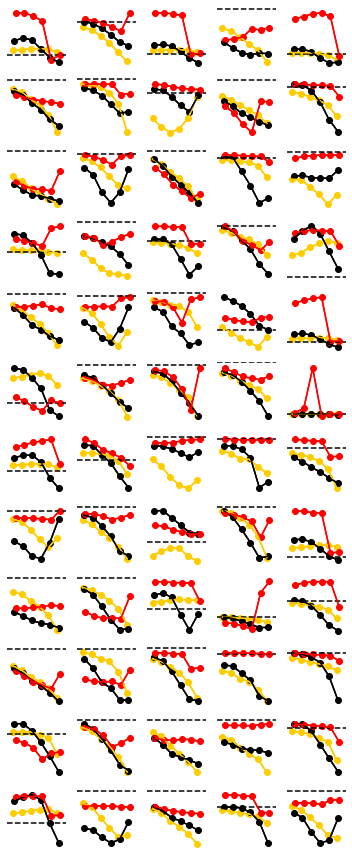

In [963]:
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10)
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10) & (YY_fix[:,1:3].max(1).max(1).max(1).max(1) < 10) & (couplings_fix[:,[1,2,4]].max(1).max(1).max(1).max(1).max(1) < 10)


i,j = 4,0
plt.figure(figsize=(2.5,2.5))
ucontrast = np.array((0,6,12,25,50,100))
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
these_couplings = np.concatenate((couplings_halo[lkat][np.arange(lkat.sum()),ilight_resmax[0][lkat],np.newaxis][:,:,isize,:,i,j],\
    couplings_baseline[lkat][:,[ilight_off]][:,:,isize,:,i,j],\
    couplings_chrimson[lkat][np.arange(lkat.sum()),ilight_resmax[1][lkat],np.newaxis][:,:,isize,:,i,j]),axis=1)
plt.figure(figsize=(5,12))
for ifit in range(60):#these_couplings.shape[0]):
    plt.subplot(12,5,ifit+1)
    ut.plot_pct_errorbars_hillel(np.arange(6),these_couplings[ifit:ifit+1],pct=(16,84),colors=colors,delta=0.1)
    plt.axis('off')
    plt.axhline(c='k',linestyle='dashed')
ut.erase_top_right()
# plt.ylabel(r'near PC response'+'\n to driving far PC')
# plt.title('22$^o$ size')
plt.xticks(np.arange(6),ucontrast)
plt.tight_layout()
# plt.savefig('figures/far_pc_near_pc_coupling_sim_vip_opto.eps')


In [861]:
these_couplings.shape

(61, 3, 6)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


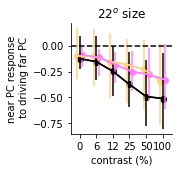

In [1085]:
lkat = (network_resp_chrimson.max(1).max(1).max(1) < 10)
lkat = (YY_fix[:,1:3].max(1).max(1).max(1).max(1) < 10) & (np.abs(couplings_fix[:,[1,2,4]]).max(1).max(1).max(1).max(1).max(1) < 5)

i,j = 4,0
plt.figure(figsize=(2.5,2.5))
ucontrast = np.array((0,6,12,25,50,100))
isize = 3
colors = np.array(((1,0.825,0.5),(0,0,0),(1,0.5,1)))
these_couplings = np.concatenate((couplings_fix[lkat][:,[1]][:,:,isize,:,i,j],\
#     couplings_baseline[lkat][:,[ilight_off]][:,:,isize,:,i,j],\
    couplings_fix[lkat][:,[4]][:,:,isize,:,i,j],\
    couplings_fix[lkat][:,[2]][:,:,isize,:,i,j]),axis=1)
plot_fn = ut.plot_pct_errorbars_hillel
plot_fn(np.arange(6),these_couplings,pct=(16,84),colors=colors,delta=0.1)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')
plt.ylabel(r'near PC response'+'\n to driving far PC')
plt.xlabel('contrast (%)')
plt.title('22$^o$ size')
plt.xticks(np.arange(6),ucontrast)
plt.tight_layout()
plt.savefig('figures/far_pc_near_pc_coupling_sim_sst_vip_fixed.eps')


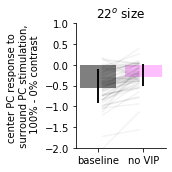

In [846]:
i,j = 4,0
plt.figure(figsize=(2.5,2.5))
icontrast1,icontrast2 = 0,5
arr1 = couplings_baseline[lkat][:,ilight_off][:,isize,:,i,j]
arr2 = couplings_fix[lkat][:,2][:,isize,:,i,j]
data1,data2 = [arr[:,icontrast2] - arr[:,icontrast1] for arr in [arr1,arr2]]
ut.plot_bars_with_lines(np.concatenate((data1[:,np.newaxis],data2[:,np.newaxis]),axis=1),colors=['k',np.array((1,0.5,1))],xticklabels=['baseline','no VIP'],errorstyle='pct',alpha=0.025)
plt.ylim((-2,1))
plt.ylabel('center PC response to \n surround PC stimulation, \n 100% - 0% contrast')
plt.title('22$^o$ size')
ut.erase_top_right()
plt.tight_layout()
# plt.savefig('figures/far_pc_coupling_sst_fixed_no_opto_dynamic_range_bars.jpg',dpi=300)


In [766]:
couplings_fix[lkat][:,1].shape

(242, 6, 6, 8, 8)

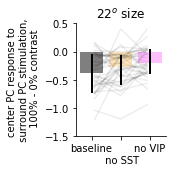

In [1086]:
i,j = 4,0
plt.figure(figsize=(2.5,2.5))
icontrast1,icontrast2 = 0,5
arr1 = couplings_fix[lkat][:,4][:,isize,:,i,j]
arr2 = couplings_fix[lkat][:,1][:,isize,:,i,j]
arr3 = couplings_fix[lkat][:,2][:,isize,:,i,j]
data1,data2,data3 = [arr[:,icontrast2] - arr[:,icontrast1] for arr in [arr1,arr2,arr3]]
datas = np.concatenate((data1[:,np.newaxis],data2[:,np.newaxis],data3[:,np.newaxis]),axis=1)
colors = ['k',np.array((1,0.825,0.5)),np.array((1,0.5,1))]
xticklabels = ['baseline','\n no SST','no VIP']
ut.plot_bars_with_lines(datas,colors=colors,xticklabels=xticklabels,errorstyle='pct',alpha=0.025)
plt.ylim((-1.5,0.5))
plt.ylabel('center PC response to \n surround PC stimulation, \n 100% - 0% contrast')
plt.title('22$^o$ size')
ut.erase_top_right()
plt.tight_layout()
plt.savefig('figures/far_pc_coupling_sst_vip_fixed_no_opto_dynamic_range_bars.jpg',dpi=300)


In [715]:
couplings_baseline[lkat][:,ilight_off].shape

(240, 6, 6, 8, 8)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-0.31206481721825163


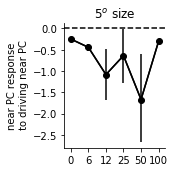

In [403]:
i,j = 4,0
plt.figure(figsize=(2.5,2.5))
ucontrast = np.array((0,6,12,25,50,100))
isize = 0
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),couplings[lkat][:,[0]][:,:,isize,:,i,j],pct=(16,84),colors=colors[1:2])
# ut.plot_bootstrapped_errorbars_hillel(np.arange(6),couplings[low_loss][:,[ilight_off]][:,:,isize,:,i,j],pct=(16,84),colors=colors[1:2])
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')
plt.ylabel(r'near PC response'+'\n to driving near PC')
plt.title('5$^o$ size')
plt.xticks(np.arange(6),ucontrast)
plt.tight_layout()
# plt.savefig('figures/near_pc_near_pc_coupling_sim_vip_opto.eps')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.0


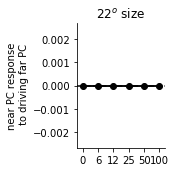

In [201]:
i,j = 4,0
plt.figure(figsize=(2.5,2.5))
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),couplings[low_loss][:,[ilight_off]][:,:,isize,:,i,j],pct=(16,84),colors=colors[1:2])
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')
plt.ylabel(r'near PC response'+'\n to driving far PC')
plt.title('22$^o$ size')
plt.xticks(np.arange(6),ucontrast)
plt.tight_layout()
# plt.savefig('figures/far_pc_near_pc_coupling.eps')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.15686076394847015
-0.06485143995261829
-0.23941055773302272
-0.0970268442658368
-0.1398307765534857
-0.22285440024273326
-0.0807831188927623
-0.03524772401727159
-0.1677246191453393
0.050540825177381545
-0.09846154187861657
-0.053330986985718885
-0.003209762287898407
-0.3198329650658203
0.01997753589636093
-0.6359062603643807
-0.09785244078721457
-0.04817591029452165
0.05914192424912602
-0.06683658788530175
-0.1051628871963274
-0.029867350563647383
-0.10271619456271863


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.02104895842887898
-0.015442709572586751
-0.11277011231740752
-0.2683044311543184
-0.1924891115133093
-0.33504746016679254
-0.021229543714734074
-0.5796198347778655
0.09726862814583315
-0.06582738479698524
-0.2210283139932979
0.18198370948548617
-0.023822803663981727
0.07766479647049873
-0.21378065618430275
-0.19268029326935704
-0.07232740607313397
-0.10469921859831188
-0.16925885088094508
0.00921086276951182
-0.13622726488229583
-0.04326792255198699
-0.043910514340962


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.12772429270120492
-0.15235135377410855
0.031023277970719427
-0.04992257791262692
-0.13702368721899524
-0.10040149420938796
-0.07630996453907814
-0.024216329145626495
0.191060262267765
-0.056620544059469174
-0.11359046744725676
-0.02706170005689708
0.1772091354640672
-0.06877689445394658
-0.3030368161252847
-0.13409381679941437
-0.24676708278009124
-0.46421380270884915
-0.03503494844743627
-0.06431674480713379
-0.013076962002493907


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.25268920595377187
-0.24769714406915813
-0.14896839615539245
-0.21631822990373098
-0.1276934031273173
-0.069213294198642
-0.034098434933428845
-0.0086861928938928
-0.1912724377457756
-0.1492595033056872
-0.03011830464572059
-0.17454410911039686
-0.029923672585640795
-0.4957061160521352
-0.09541669733339846
-0.0031537140330252095
-0.19986874568843305
-0.15545325886678807
-0.40301161967082105
-0.14334475270933597
-0.18718655928968025


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.1904343144720196
-0.048237230409027415
-0.25572277816331584
-0.04126779196466589
-0.019929422986151694
-0.061888036981486115
-0.2577492269454373
-0.11560517512905598
-0.035485903279076386
-0.2968627435835294
-0.02727418499882983
0.03820843827298045
0.26418963883928254
-0.14832872979725745
-0.1609920800013049
-0.004028882580729394
-0.12032452707602621
-0.21977023406357005
-0.1102426679418318
-0.06248168011946387
-0.25835031626088834


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.01805488190473575
-0.08217368411482574
-0.21944662029576878
-0.02355106895592442
-0.05979450150283373
-0.25628105944175233
0.09128376202443024
-0.012441661369459265
0.16233603616726108
-0.028153178321032445
-0.10872981242640808
-0.06876581619432805
-0.34193402045983345
-0.01344957569806804
-0.015970690271152593
-0.1372401596275143
0.029526007893609665
-0.08402386092054176
-0.06947866587213487
-0.07433156152119905


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.046803690848202975
-0.04599324365419949
0.02734454742578013
0.9168151219417909


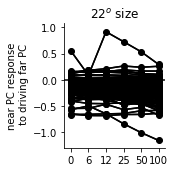

In [583]:
i,j = 4,0
plt.figure(figsize=(2.5,2.5))
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
for iwt in range(couplings.shape[0]):
    ut.plot_bootstrapped_errorbars_hillel(np.arange(6),couplings[iwt:iwt+1,[ilight_off]][:,:,isize,:,i,j],pct=(16,84),colors=colors[1:2])
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')
plt.ylabel(r'near PC response'+'\n to driving far PC')
plt.title('22$^o$ size')
plt.xticks(np.arange(6),ucontrast)
plt.tight_layout()
# plt.savefig('figures/far_pc_near_pc_coupling.eps')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


2.6280033096800004


Text(0.5, 1.0, '22$^o$ size')

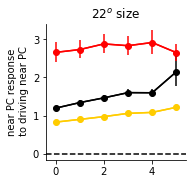

In [635]:
i,j = 0,0
plt.figure(figsize=(2.5,2.5))
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),couplings[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i,j],pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')
plt.ylabel(r'near PC response'+'\n to driving near PC')
plt.title('22$^o$ size')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


4.006681161509711


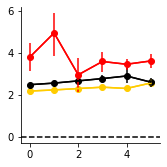

In [616]:
i,j = 0,0
plt.figure(figsize=(2.5,2.5))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
this_data = couplings[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i,j]/phis[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i]
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),this_data,pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.8638361763516298


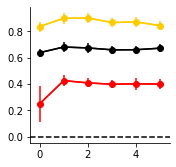

In [446]:
i,j = 2,0
plt.figure(figsize=(2.5,2.5))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
this_data = couplings[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i,j]/phis[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i]/phis[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,j]
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),this_data,pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.21165343296713277


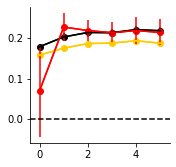

In [447]:
i,j = 2,0
plt.figure(figsize=(2.5,2.5))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
this_data = couplings[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i,j]
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),this_data,pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


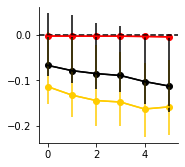

In [448]:
i,j = 1,0
plt.figure(figsize=(2.5,2.5))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
this_data = couplings[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i,j]
ut.plot_pct_errorbars_hillel(np.arange(6),this_data,pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.770586616984359


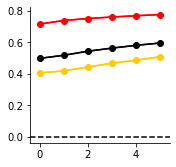

In [449]:
i = 0
plt.figure(figsize=(2.5,2.5))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),phis[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i],pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.6635194814302638


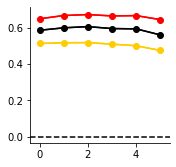

In [450]:
i = 2
plt.figure(figsize=(2.5,2.5))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),phis[:,[ilight_halo,ilight_off,ilight_chrimson]][:,:,isize,:,i],pct=(16,84),colors=colors)
ut.erase_top_right()
plt.axhline(c='k',linestyle='dashed')

ValueError: num must be 1 <= num <= 100, not 101

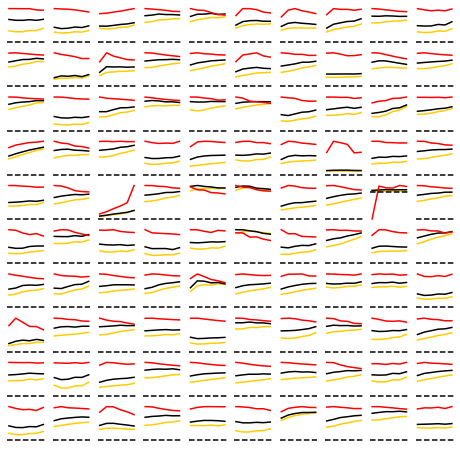

In [451]:
i,j = 0,0
plt.figure(figsize=(8,8))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
for iwt in range(nwt):
    plt.subplot(10,10,iwt+1)
    for iilight,ilight in enumerate([ilight_halo,ilight_off,ilight_chrimson]):
        plt.plot(np.arange(6),couplings[iwt,ilight,isize,:,i,j],c=colors[iilight])
    ut.erase_top_right()
    plt.axhline(c='k',linestyle='dashed')
    plt.axis('off')

ValueError: num must be 1 <= num <= 100, not 101

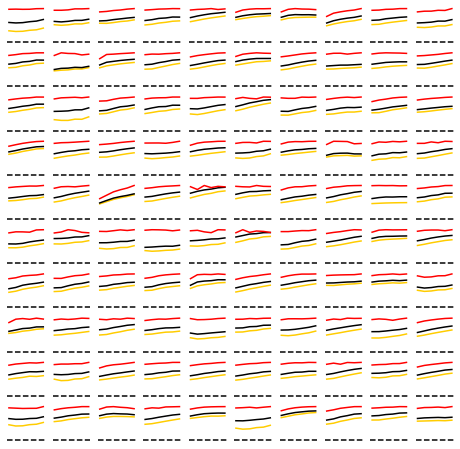

In [452]:
i = 0
plt.figure(figsize=(8,8))
iwt = 3
isize = 3
colors = np.array(((1,0.8,0),(0,0,0),(1,0,0)))
for iwt in range(nwt):
    plt.subplot(10,10,iwt+1)
    for iilight,ilight in enumerate([ilight_halo,ilight_off,ilight_chrimson]):
        plt.plot(np.arange(6),phis[iwt,ilight,isize,:,i],c=colors[iilight])
    ut.erase_top_right()
    plt.axhline(c='k',linestyle='dashed')
    plt.axis('off')

In [ ]:
YY_opto_medium.shape

In [617]:
reload(ut)
reload(sca)
average_last = int(np.floor(Niter/5))
lbls = ['PC','SST','VIP','PV']
opto_lbls = ['halo','chrimson']
nopto = len(opto_levels)
ncelltypes = YY_opto_medium[0].shape[-1]
YY_opto_tavg = np.zeros((nwt,nopto,6,6,ncelltypes))
for iwt in range(nwt):
    YY_opto_tavg[iwt] = np.nanmean(YY_opto_medium[iwt][:,:,-average_last:,:],2).reshape((nopto,6,6,ncelltypes))
iwt = -1
ilight1 = 5
for iilight2,ilight2 in enumerate([2,6]):
    for itype in range(3):
        plt.figure(figsize=(12,2))
        for iwt in range(6):#nwt):
            plt.subplot(1,6,iwt+1)
            xdata = YY_opto_tavg[iwt,ilight1,:,:,itype]
            ydata = YY_opto_tavg[iwt,ilight2,:,:,itype]
            sca.scatter_size_contrast(xdata,ydata,mn=0)
            ut.erase_top_right()
#         ut.zero_origin('xy')
            plt.xlabel('%s event rate, \n light off'%lbls[itype])
            plt.ylabel('%s event rate, \n light on'%lbls[itype])
        plt.tight_layout()
#         plt.savefig('figures/finite_%s_%s_scatter_light_on_light_off.eps'%(opto_lbls[iilight2],lbls[itype]))

ValueError: cannot reshape array of size 4896 into shape (21,6,6,8)

In [638]:
YY_opto_tavg.shape

(134, 21, 6, 6, 8)

In [639]:
np.save('../shared_data/opto_sim_data.npy',{'YY_opto':YY_opto_tavg[low_loss]})

(array([ 1.,  1.,  1.,  1.,  2.,  4., 12., 27., 25., 15.]),
 array([-0.09185796, -0.05309753, -0.0143371 ,  0.02442333,  0.06318376,
         0.10194419,  0.14070462,  0.17946505,  0.21822547,  0.2569859 ,
         0.29574633]),
 <a list of 10 Patch objects>)

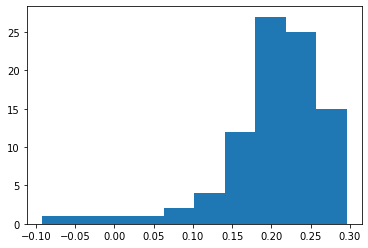

In [50]:
plt.figure()
plt.hist(bltiles[:,0])

True

(11, 36, 101, 8)

In [ ]:
plt.figure()
sca.scatter_size_contrast(YY_opto_medium[-1][:,:,:,])

In [48]:
usize = np.array([5,8,13,22,36,60])
ucontrast = np.array([0,6,12,25,50,100])

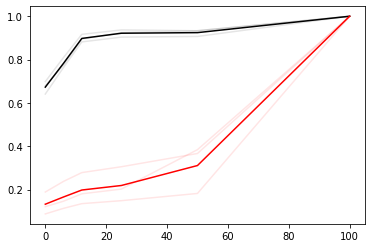

In [49]:
ilights = [5,10]
colors = ['k','r']
isize = -1
plt.figure()
for ilight,color in zip(ilights,colors):
    data = np.nanmean(YY_opto_medium[:,ilight,:,:,0],2).reshape((-1,6,6))
    this_data = data[:,isize,:]/data[:,isize,:].max(1)[:,np.newaxis]
    plt.plot(ucontrast,this_data.T,c=color,alpha=0.1)
    plt.plot(ucontrast,np.mean(this_data,0),c=color)

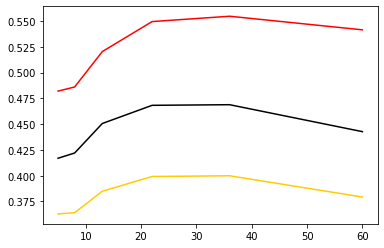

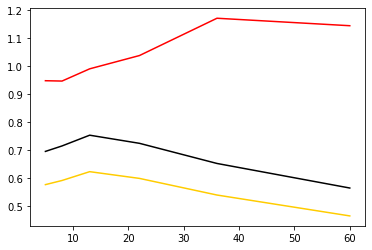

In [37]:
ilights = [1,5,9]
colors = [np.array((1,0.8,0)),'k','r']
nlights = len(ilights)
smi = np.zeros((YY_opto_medium.shape[0],nlights,6))
itype = 0
for iilight,ilight in enumerate(ilights):
    data = np.nanmean(YY_opto_medium[:,ilight,:,:,itype],2).reshape((-1,6,6))
    smi[:,iilight] = data[:,-1,:]/np.max(data,axis=1)
    
for icontrast in [1,5]:
    plt.figure()
    for ilight,color in zip(ilights,colors):
        data = np.nanmean(YY_opto_medium[:,ilight,:,:,itype],2).reshape((-1,6,6))
        this_data = data[:,:,icontrast]#/data[:,:,icontrast].max(1)[:,np.newaxis]
#         plt.plot(usize,this_data.T,c=color,alpha=0.1)
        plt.plot(usize,np.mean(this_data,0),c=color)

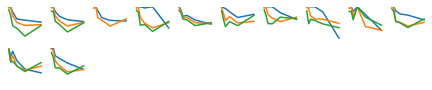

In [16]:
plt.figure(figsize=(7.5,7.5))
for iwt in range(nwt):
    plt.subplot(10,10,iwt+1)
    plt.plot(ucontrast,smi[iwt,:,:].T)
    plt.ylim((0.5,1))
    plt.axis('off')

In [17]:
plt.figure()
plt.plot(ucontrast,smi[68].T)

IndexError: index 68 is out of bounds for axis 0 with size 12

<Figure size 432x288 with 0 Axes>

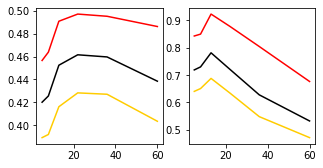

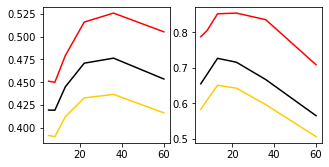

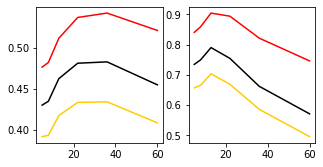

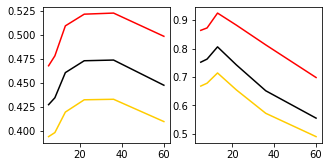

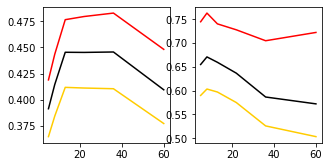

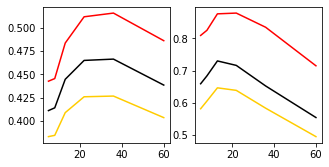

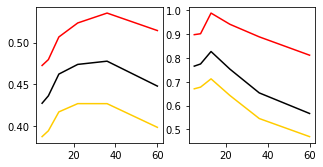

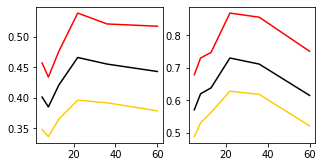

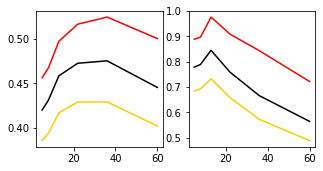

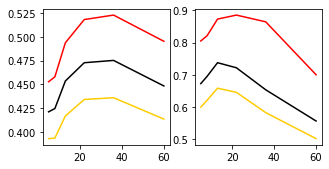

In [38]:
for iwt in range(nwt):
    ilights = [3,5,7]
    colors = [np.array((1,0.8,0)),'k','r']
    nlights = len(ilights)

    plt.figure(figsize=(5,2.5))
    for iicontrast,icontrast in enumerate([1,5]):
        plt.subplot(1,2,iicontrast+1)
        for ilight,color in zip(ilights,colors):
            data = np.nanmean(YY_opto_medium[iwt,ilight,:,:,itype],1).reshape((-1,6,6))
            this_data = data[:,:,icontrast]#/data[:,:,icontrast].max(1)[:,np.newaxis]
    #         plt.plot(usize,this_data.T,c=color,alpha=0.1)
            plt.plot(usize,np.nanmean(this_data,0),c=color)

In [43]:
np.nanmean(YY_opto_medium[:,:,:,:,itype],3).reshape((nwt,-1,6,6))[:,:,[0,2,3,5],:].shape

(10, 11, 4, 6)

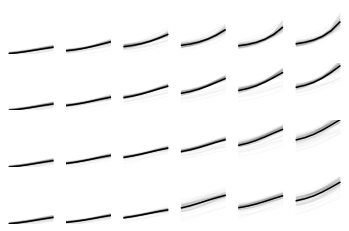

In [67]:
data = np.nanmean(YY_opto_medium[:,2:8,:,:,itype],3).reshape((nwt,-1,6,6))[:,:,[0,2,3,5],:]
nsize,ncontrast = 4,6
mn = np.nanmean(data,0).min()
mx = np.nanmean(data,0).max()
plt.figure()
for isize in range(nsize):
    for icontrast in range(ncontrast):
        plt.subplot(nsize,ncontrast,(nsize-isize-1)*ncontrast+icontrast+1)
        plt.plot(data[:,:,isize,icontrast].T,c='k',alpha=0.02)
        plt.plot(np.nanmean(data[:,:,isize,icontrast],0),c='k')
        plt.ylim((mn,mx))
        plt.axis('off')
plt.savefig('figures/vip_sim_master_plot.jpg',dpi=300)

In [177]:
YY_opto_medium[0,7,:,:,itype]

array([[0.49249911, 0.49249911, 0.49249911, ..., 0.49249911, 0.49249911,
        0.49249911],
       [0.54827048, 0.54827048, 0.54827048, ..., 0.54827048, 0.54827048,
        0.54827048],
       [0.60918797, 0.60918797, 0.60918797, ..., 0.60918797, 0.60918797,
        0.60918797],
       ...,
       [0.7447089 , 0.7447089 , 0.7447089 , ..., 0.7447089 , 0.7447089 ,
        0.7447089 ],
       [0.73623515, 0.73623515, 0.73623515, ..., 0.73623515, 0.73623515,
        0.73623515],
       [0.75386399, 0.75386399, 0.75386399, ..., 0.75386399, 0.75386399,
        0.75386399]])

In [143]:
# for iwt in range(nwt):
#     plt.figure()
#     for ilight,isize,icontrast in zip([0,5,10],[4,4,4],[5,5,5]):
#         tmax = Niter
#         t = np.arange(tmax)*dt
#         iflat = np.ravel_multi_index((isize,icontrast),(nsize,ncontrast))
#         plt.plot(t,YY_opto[iwt][ilight,iflat,:tmax,0].T)

In [168]:
np.nanmax(data)

0.0

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


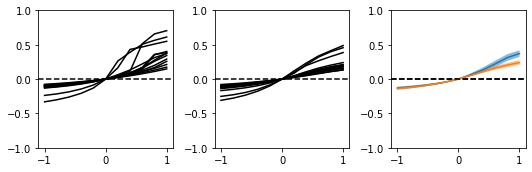

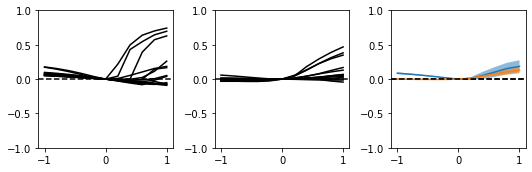

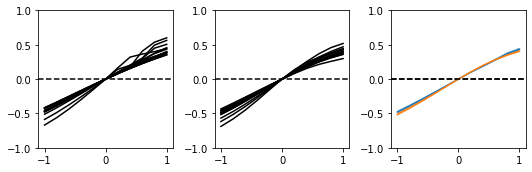

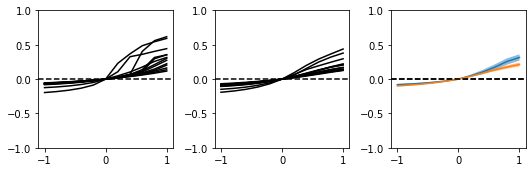

In [234]:
iwt = 0
data = np.zeros((nwt,YY_opto_medium[0].shape[0],6,6))
these_lvls = slice(None)
for itype in [0,1,2,3]:
    plt.figure(figsize=(7.5,2.5))
    isize = 3
    tlast = 1000
    icontrasts = [1,5]
    for iwt in range(nwt):
        data[iwt] = np.nanmean(YY_opto_medium[iwt][:,:,:,itype],2).reshape((-1,6,6)) # light, stim, time, type
        data[iwt] = (data[iwt] - data[iwt,5])/(data[iwt] + data[iwt,5])
    for iicontrast,icontrast in enumerate(icontrasts):
        this_data = data[:,:,isize,icontrast]
        plt.subplot(1,3,iicontrast+1)
        for iwt in range(nwt):
            plt.plot(opto_levels[these_lvls],this_data[iwt][these_lvls],c='k',alpha=1)
        plt.plot(opto_levels[these_lvls],np.mean(this_data,0)[these_lvls],c='k')
        plt.ylim((np.nanmin(data[:,:,isize,icontrasts]),np.nanmax(data[:,:,isize,icontrasts])))
        plt.axhline(0,c='k',linestyle='dashed')
        plt.ylim(-1,1)
        plt.subplot(1,3,3)
        mn = np.mean(this_data,0)[these_lvls]
        sem = np.std(this_data,0)[these_lvls]/np.sqrt(this_data.shape[0])
        plt.plot(opto_levels[these_lvls],mn)
        plt.fill_between(opto_levels[these_lvls],mn-sem,mn+sem,alpha=0.5)
        plt.ylim((np.nanmin(data[:,:,isize,icontrasts]),np.nanmax(data[:,:,isize,icontrasts])))
        plt.axhline(0,c='k',linestyle='dashed')
        plt.ylim(-1,1)
    plt.tight_layout()

In [136]:
non_paradoxical = (YY_opto_small[:,10,:,1] - YY_opto_small[:,5,:,1]>0).sum(1) == 0

In [ ]:
iwt,ilight = 0,-1
thisYY = np.nanmean(YY_opto[iwt,:,:,:],2)
mdls[0].fprimeY(thisYY).shap

In [160]:
YY_opto.shape

(10, 11, 36, 10001, 16)

In [162]:
this_fprime = mdls[0].fprimeY(np.nanmean(YY_opto[iwt],2))
this_fprime.shape

(11, 36, 16)

In [84]:
nlight = YY_opto_medium.shape[1]
nN,nP,nQ,nS,nT = [getattr(mdls[0],x) for x in ['nN','nP','nQ','nS','nT']]
phis = np.zeros((nwt,nlight,6,6,nQ*nS*nT))
couplings = np.zeros((nwt,nlight,6,6,nQ*nS*nT,nQ*nS*nT))
Xcouplings = np.zeros((nwt,nlight,6,6,nP*nS*nT,nQ*nS*nT))
for iwt,mdl in enumerate(mdls[:nwt]):
    print('model #%d'%iwt)
    this_fprime = mdl.fprimeY(np.nanmean(YY_opto_medium[iwt],2))
    WWmx,WWmy = [getattr(mdls[iwt],x) for x in ['WWmx','WWmy']]
    for ilight in range(nlight):
        for istim in range(nN):
            iistim,jjstim = np.unravel_index(istim,(6,6))
            phis[iwt,ilight,iistim,jjstim] = this_fprime[ilight,istim]
            Phi = np.diag(phis[iwt,ilight,iistim,jjstim])
            couplings[iwt,ilight,iistim,jjstim] = Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
            Xcouplings[iwt,ilight,iistim,jjstim] = WWmx @ Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
# couplings = np.reshape(couplings,(couplings.shape[0],6,6,couplings.shape[2],couplings.shape[3]))
# Xcouplings = np.reshape(Xcouplings,(Xcouplings.shape[0],6,6,Xcouplings.shape[2],Xcouplings.shape[3]))


model #0
model #1
model #2
model #3
model #4
model #5
model #6
model #7
model #8
model #9
model #10
model #11
model #12
model #13
model #14
model #15
model #16
model #17
model #18
model #19
model #20
model #21
model #22
model #23
model #24
model #25
model #26
model #27
model #28
model #29
model #30
model #31
model #32
model #33
model #34
model #35
model #36
model #37
model #38
model #39
model #40
model #41
model #42
model #43
model #44
model #45
model #46
model #47
model #48
model #49
model #50
model #51
model #52
model #53
model #54
model #55
model #56
model #57
model #58
model #59
model #60
model #61
model #62
model #63
model #64
model #65
model #66
model #67
model #68
model #69
model #70
model #71
model #72
model #73
model #74
model #75
model #76
model #77
model #78
model #79
model #80
model #81
model #82
model #83
model #84
model #85
model #86
model #87
model #88
model #89
model #90
model #91
model #92
model #93
model #94
model #95
model #96
model #97
model #98
model #99
model #100

In [85]:
lbls = ['PC','SST','VIP','PV']

In [86]:
iwt = 1

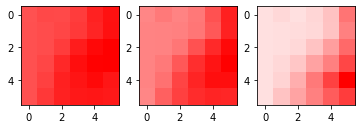

In [87]:
plt.figure()
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    data = couplings[iwt,5*ilight,:,:,1,1]
    mx = np.max(np.abs(data))
    plt.imshow(data,vmin=-mx,vmax=mx,cmap='bwr')

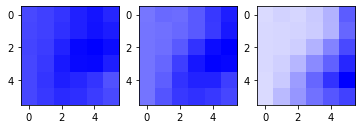

In [88]:
plt.figure()
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    data = couplings[iwt,5*ilight,:,:,2,1]
    mx = np.max(np.abs(data))
    plt.imshow(data,vmin=-mx,vmax=mx,cmap='bwr')

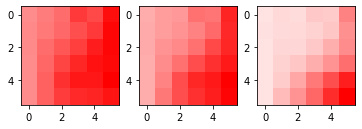

In [89]:
plt.figure()
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    data = couplings[iwt,5*ilight,:,:,2,0]
    mx = np.max(np.abs(data))
    plt.imshow(data,vmin=-mx,vmax=mx,cmap='bwr')

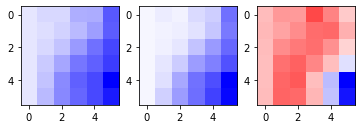

In [104]:
plt.figure()
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    data = couplings[1,5*ilight,:,:,8,0]
    mx = np.max(np.abs(data))
    plt.imshow(data,vmin=-mx,vmax=mx,cmap='bwr')

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


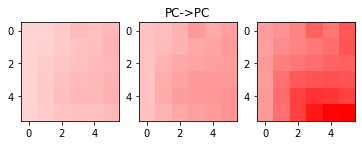

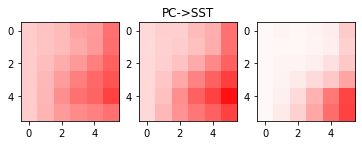

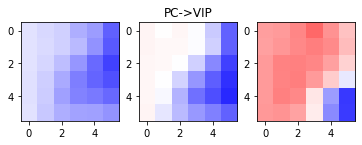

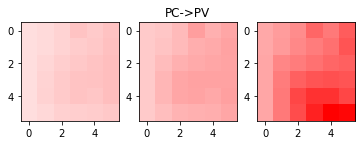

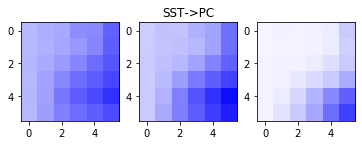

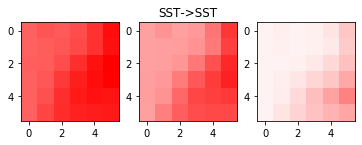

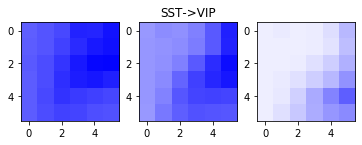

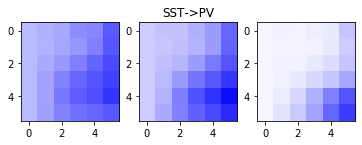

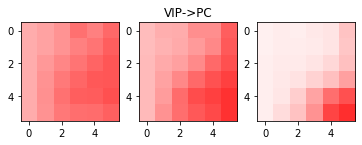

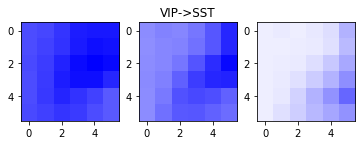

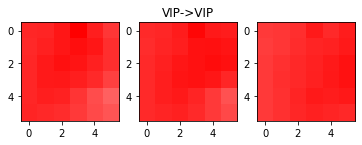

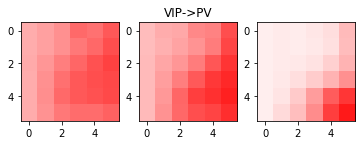

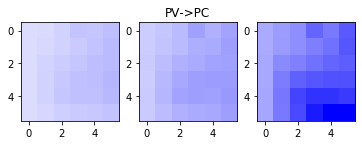

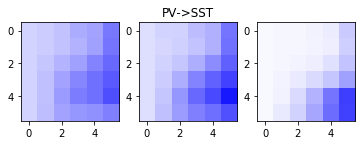

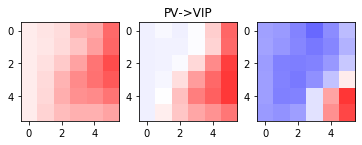

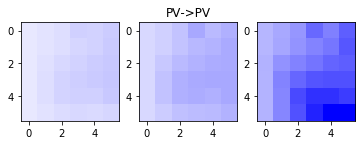

In [93]:
for itype1 in range(nQ):
    for itype2 in range(nQ):
        plt.figure()
        data = np.nanmedian(couplings[:,:,:,:,itype1,itype2],0)
        mx = np.max(np.abs(data))
        for ilight in range(3):
            plt.subplot(1,3,ilight+1)
            this_data = data[5*ilight]
            plt.imshow(this_data,vmin=-mx,vmax=mx,cmap='bwr')
        plt.subplot(1,3,2)
        plt.title('%s->%s'%(lbls[itype1],lbls[itype2]))

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


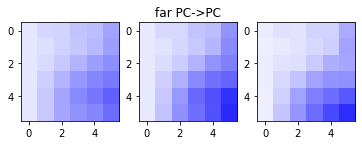

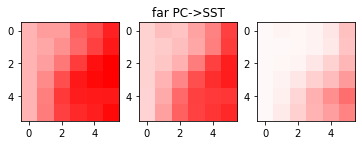

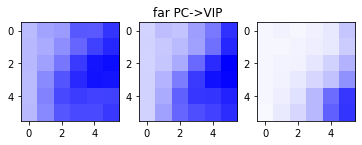

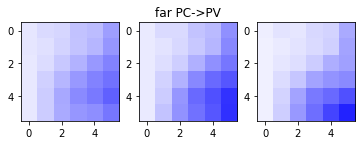

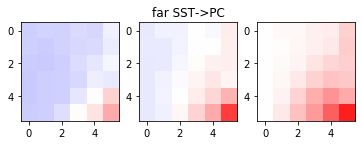

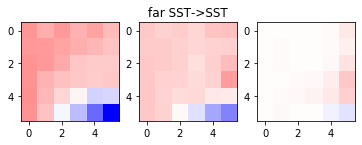

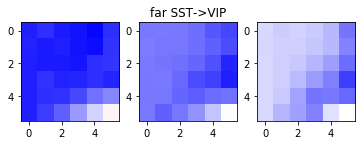

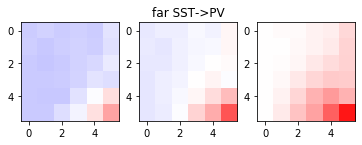

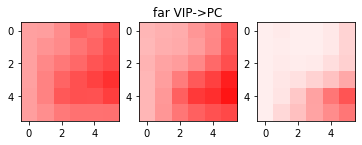

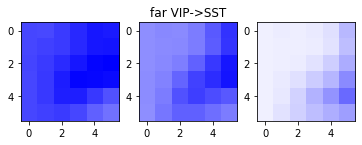

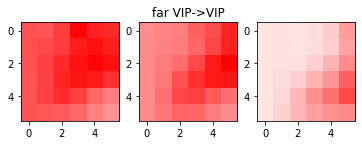

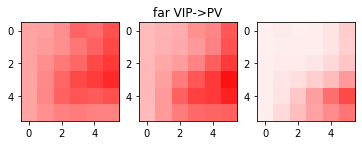

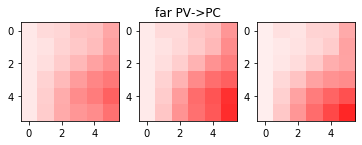

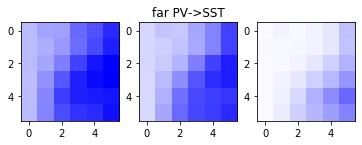

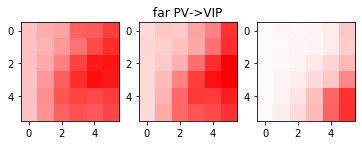

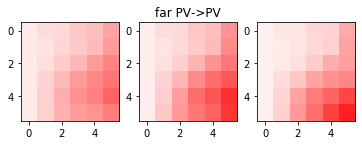

In [97]:
for itype1 in range(nQ):
    for itype2 in range(nQ):
        plt.figure()
        data = np.nanmedian(couplings[:,:,:,:,8+itype1,itype2],0)
        mx = np.max(np.abs(data))
        for ilight in range(3):
            plt.subplot(1,3,ilight+1)
            this_data = data[5*ilight]
            plt.imshow(this_data,vmin=-mx,vmax=mx,cmap='bwr')
        plt.subplot(1,3,2)
        plt.title('far %s->%s'%(lbls[itype1],lbls[itype2]))

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


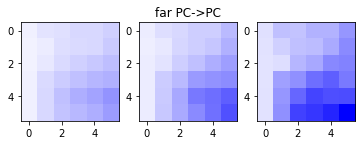

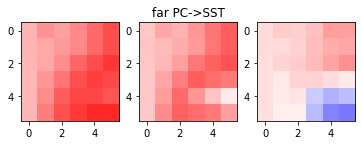

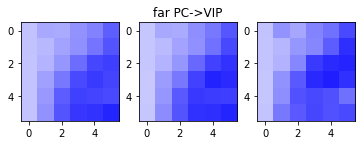

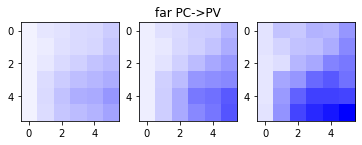

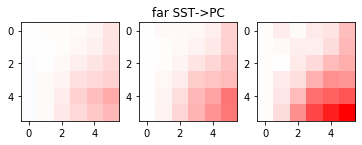

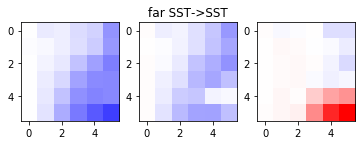

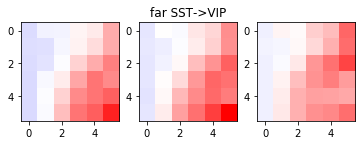

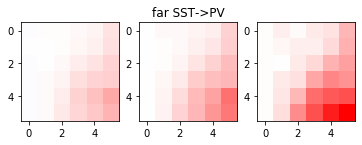

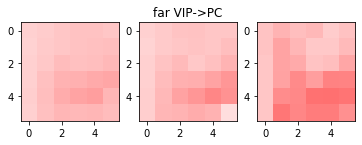

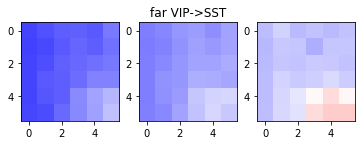

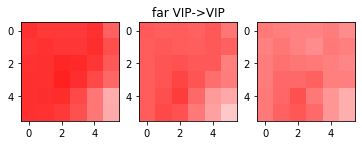

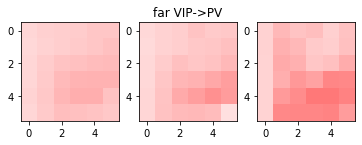

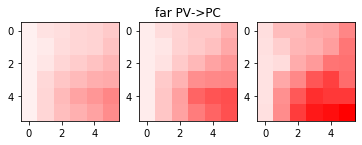

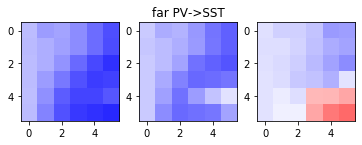

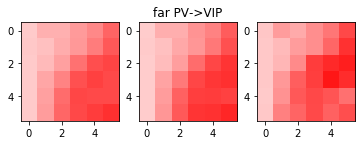

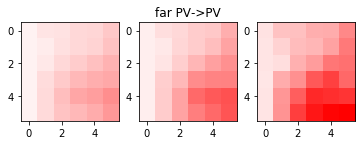

In [133]:
for itype1 in range(nQ):
    for itype2 in range(nQ):
        plt.figure()
        data = np.nanmedian(couplings[:,:,:,:,8+itype1,itype2],0)
        mx = np.max(np.abs(data))
        for ilight in range(3):
            plt.subplot(1,3,ilight+1)
            this_data = data[5+2*(ilight-1)]
            plt.imshow(this_data,vmin=-mx,vmax=mx,cmap='bwr')
        plt.subplot(1,3,2)
        plt.title('far %s->%s'%(lbls[itype1],lbls[itype2]))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-0.29041152623994315


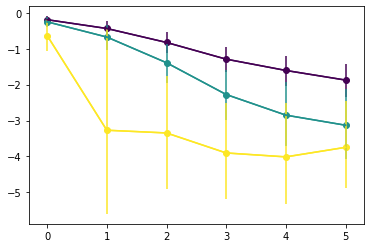

In [134]:
plt.figure()
isize = 4
x = np.arange(6)
ut.plot_bootstrapped_errorbars_hillel(x,couplings[:,[3,5,7],isize,:,8,0].transpose((1,0,2)))

In [236]:
nlight = YY_opto_medium.shape[1]
nsize,ncontrast = 6,6
nN,nP,nQ,nS,nT = [getattr(mdls[0],x) for x in ['nN','nP','nQ','nS','nT']]
max_eig = np.zeros((len(weights_files),nlight,nsize,ncontrast))
min_eig = np.zeros((len(weights_files),nlight,nsize,ncontrast))
vs = np.zeros((len(weights_files),nlight,nsize,ncontrast,2,2))
for iwt,mdl in enumerate(mdls[:nwt]):
    print('model #%d'%iwt)
    this_fprime = mdl.fprimeY(np.nanmean(YY_opto_medium[iwt],2))
    Wmy = getattr(mdls[iwt],'Wmy')
    for ilight in range(nlight):
        Weff = np.zeros((nsize,ncontrast,2,2))
        for istim in range(nN):
            iistim,jjstim = np.unravel_index(istim,(nsize,ncontrast))
            these_phis = this_fprime[ilight,istim]
            Phi = np.diag(these_phis)
            Weff[iistim,jjstim] = Wmy[[0,3]][:,[0,3]] @ Phi[[0,3]][:,[0,3]]
        for istim in range(nN):
            iistim,jjstim = np.unravel_index(istim,(nsize,ncontrast))
    #         plt.subplot(nsize,ncontrast,istim+1)
    #         plt.imshow(Weff[iistim,jjstim],vmin=Weff.min(),vmax=Weff.max())
            w,v = np.linalg.eig(Weff[iistim,jjstim].T)
            vs[iwt,ilight,iistim,jjstim] = v[:,np.argsort(w)]
            max_eig[iwt,ilight,iistim,jjstim] = np.max(w)
            min_eig[iwt,ilight,iistim,jjstim] = np.min(w)

model #0
model #1
model #2


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


model #3
model #4
model #5
model #6
model #7
model #8
model #9
model #10
model #11


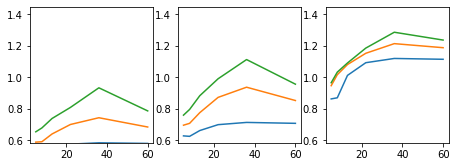

In [237]:
iwt = 0
usize = np.array([5,8,13,22,36,60])
plt.figure(figsize=(7.5,2.5))
for isize in range(3):
    plt.subplot(1,3,isize+1)
    plt.plot(usize,np.nanmean(max_eig[:,1+4*isize][:,:,[1,3,5]],0))
    plt.ylim((max_eig[iwt].min(),max_eig[iwt].max()))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

1.0145685939215443
0.8916807709116606
1.0797529009057312


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


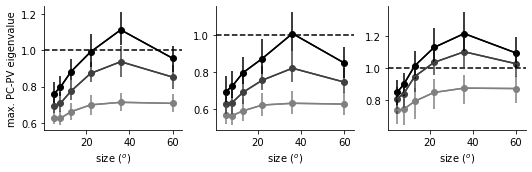

In [238]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_l23 = np.array(((0.5,0.5,0.5),(0.25,0.25,0.25),(0.,0.,0.)))
for iilight,ilight in enumerate([5,3,7]):
    plt.subplot(1,3,iilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,max_eig[:,ilight][:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_l23)
    plt.axhline(1,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    # plt.legend(['6%','25%','100%'])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
#     plt.ylim((0.4,1.3))
plt.subplot(1,3,1)
plt.ylabel('max. PC-PV eigenvalue')

plt.tight_layout()
# plt.savefig('figures/pc_pv_stability_size_by_3_contrasts_by_vip_opto.eps')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-0.37362518360617425
-0.5689124882643577


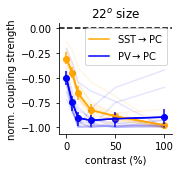

In [239]:
plt.figure(figsize=(2.5,2.5))
isize = 3
ilight = 5
datas = [couplings[:,ilight,isize,:,1,0],couplings[:,ilight,isize,:,3,0]]
colors = [np.array((1,0.65,0)),np.array((0,0,1))]
for data,color in zip(datas,colors):
    mx = np.max(np.abs(data),axis=1)[:,np.newaxis]
    ut.plot_bootstrapped_errorbars_hillel(ucontrast,(data/mx)[:,np.newaxis],pct=(2.5,97.5),colors=color[np.newaxis])
plt.legend([r'SST$\rightarrow$PC',r'PV$\rightarrow$PC'])
for data,color in zip(datas,colors):
    mx = np.max(np.abs(data),axis=1)[:,np.newaxis]
    plt.plot(ucontrast,(data/mx).T,alpha=0.1,c=color)
plt.xlabel('contrast (%)')
plt.ylabel('norm. coupling strength')
plt.title('%d$^o$ size'%usize[isize])
plt.axhline(0,linestyle='dashed',c='k')
ut.erase_top_right()
plt.tight_layout()
# plt.savefig('figures/sst_pc_coupling_traces.jpg',dpi=300)

In [240]:
max_eig[:,3+2*isize,:,[1,3,5]].shape

(3, 12, 6)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


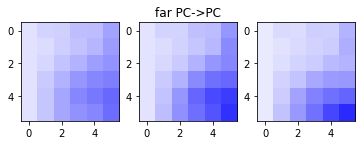

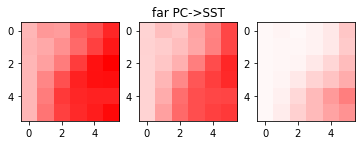

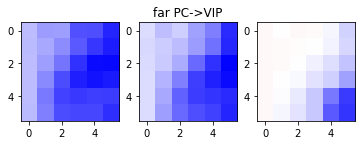

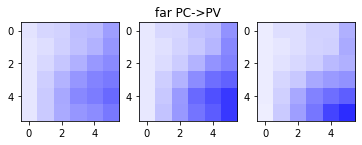

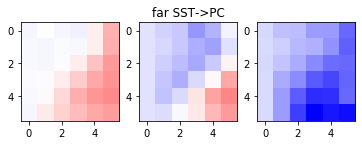

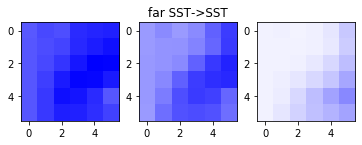

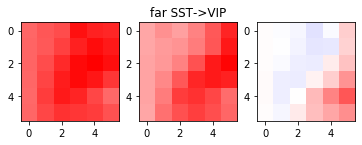

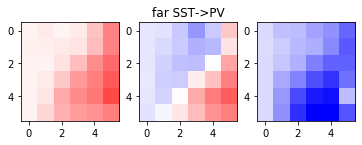

In [125]:
for itype1 in range(nP):
    for itype2 in range(nQ):
        plt.figure()
        data = np.nanmedian(Xcouplings[:,:,:,:,4+itype1,itype2],0)
        mx = np.max(np.abs(data))
        for ilight in range(3):
            plt.subplot(1,3,ilight+1)
            this_data = data[5*ilight]
            plt.imshow(this_data,vmin=-mx,vmax=mx,cmap='bwr')
        plt.subplot(1,3,2)
        plt.title('far %s->%s'%(lbls[itype1],lbls[itype2]))

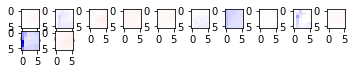

In [253]:
plt.figure()
mx = np.max(np.abs(couplings[:,10,:,:,1,1]))
for iwt in range(nwt):
    plt.subplot(10,10,iwt+1)
    plt.imshow(couplings[iwt,10,:,:,1,1],vmin=-mx,vmax=mx,cmap='bwr')
#     plt.axis('off')
cp = couplings.reshape((nwt,-1))
lkat = np.ones((nwt,),dtype='bool')
# lkat = np.max(np.abs(cp),axis=1)<50

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.33952617519641554
0.22530867720703426
-0.16359281323725525


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


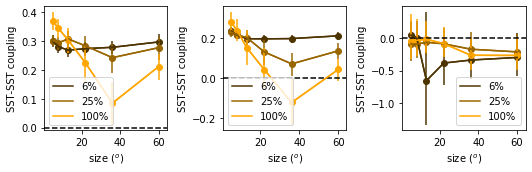

In [243]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,couplings[:,1+4*ilight,:,:,1,1][:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_sst)
    plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('SST-SST coupling')
    plt.legend(['6%','25%','100%'])
    plt.tight_layout()
# plt.savefig('figures/sst_sst_coupling_size_by_3_contrasts_by_3_light_levels.eps')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.7392399859517991
0.8049114596481154


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.9204735168743363


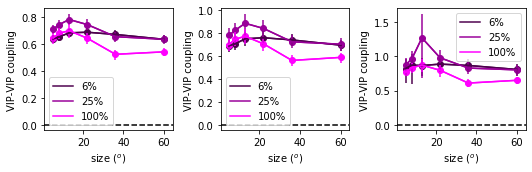

In [244]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,couplings[lkat,3+2*ilight,:,:,2,2][:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_vip)
    plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('VIP-VIP coupling')
    plt.legend(['6%','25%','100%'])
    plt.tight_layout()
# plt.savefig('figures/vip_sst_coupling_size_by_3_contrasts_by_3_light_levels.eps')

NameError: name 'lkat' is not defined

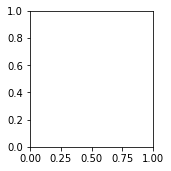

In [116]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,couplings[lkat,1+4*ilight,:,:,2,1][:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_vip)
    plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('VIP-SST coupling')
    plt.legend(['6%','25%','100%'])
    plt.tight_layout()
# plt.savefig('figures/vip_sst_coupling_size_by_3_contrasts_by_3_light_levels.eps')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

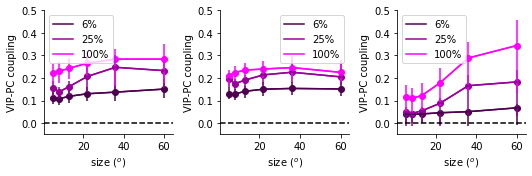

In [122]:
reload(ut)
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for iilight,ilight in enumerate([5,1,9]):
    plt.subplot(1,3,iilight+1)
    ut.plot_pct_errorbars_hillel(usize,couplings[:,ilight,:,:,2,0][:,:,[1,3,5]].transpose((0,2,1)),pct=(16,84),colors=c_vip)
    plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('VIP-PC coupling')
    plt.legend(['6%','25%','100%'])
    ut.erase_top_right()
    plt.tight_layout()
    plt.ylim(-0.05,0.5)
# plt.savefig('figures/vip_pc_coupling_size_by_3_contrasts_by_3_light_levels.eps')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

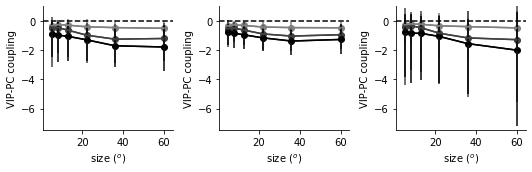

In [120]:
reload(ut)
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for iilight,ilight in enumerate([5,1,9]):
    plt.subplot(1,3,iilight+1)
    ut.plot_pct_errorbars_hillel(usize,couplings[:,ilight,:,:,8,0][:,:,[1,3,5]].transpose((0,2,1)),pct=(16,84),colors=c_l23)
    plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('VIP-PC coupling')
#     plt.legend(['6%','25%','100%'])
    ut.erase_top_right()
    plt.tight_layout()
    plt.ylim(-7.5,1)
# plt.savefig('figures/vip_pc_coupling_size_by_3_contrasts_by_3_light_levels.eps')

In [151]:
sc = YY_opto_small.reshape(YY_opto_small.shape[:2]+(6,6,-1))

In [152]:
smi = sc[:,:,-1,1:,0]/np.max(sc[:,:,:,1:,0],axis=2)

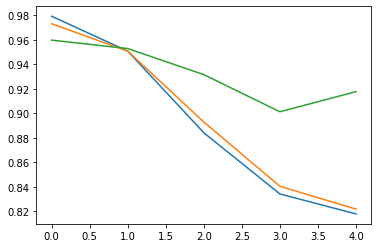

In [153]:
plt.figure()
for ilight in [5,1,9]:
    plt.plot(np.nanmean(smi[:,ilight,:],0))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.7278878753225566
0.6141257398117157


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


1.0227992465695759


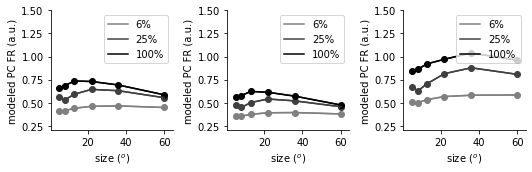

In [123]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for iilight,ilight in enumerate([5,1,9]):
    plt.subplot(1,3,iilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,YY_opto_small[:,ilight,:,0].reshape((-1,6,6))[:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_l23)
#     plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('modeled PC FR (a.u.)')
    plt.legend(['6%','25%','100%'])
    ut.erase_top_right()
    plt.ylim(0.2,1.5)
plt.tight_layout()
# plt.savefig('figures/modeled_pc_size_by_3_contrasts_by_3_light_levels.eps')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.595975275563359
0.13255265470553373
1.3652119077072997


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


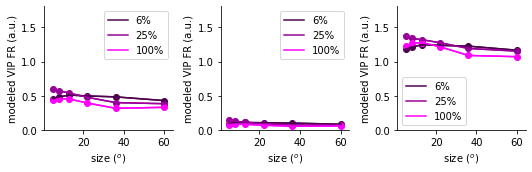

In [124]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for iilight,ilight in enumerate([5,1,9]):
    plt.subplot(1,3,iilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,YY_opto_small[:,ilight,:,2].reshape((-1,6,6))[:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_vip)
#     plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('modeled VIP FR (a.u.)')
    plt.legend(['6%','25%','100%'])
    ut.erase_top_right()
    plt.tight_layout()
    plt.ylim(0.,1.8)
# plt.savefig('figures/modeled_vip_size_by_3_contrasts_by_3_light_levels.eps')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.7550497002352771
0.6076441236465289
0.9027097557828473


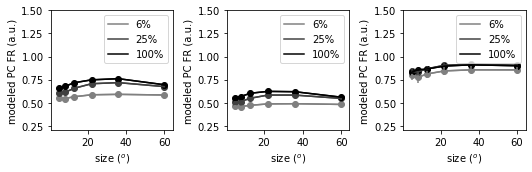

In [156]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for iilight,ilight in enumerate([5,1,9]):
    plt.subplot(1,3,iilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,phis[:,ilight,:,:,0][:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_l23)
#     plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('modeled PC FR (a.u.)')
    plt.legend(['6%','25%','100%'])
    plt.tight_layout()
    plt.ylim(0.2,1.5)
# plt.savefig('figures/modeled_pc_size_by_3_contrasts_by_3_light_levels.eps')

In [284]:
phis.shape

(84, 11, 6, 6, 16)

In [207]:
couplings.shape

(84, 6, 6, 16, 16)

In [106]:
c_l4 = np.array(((0,0.3,0),(0,0.6,0),(0,1,0)))
c_l23 = np.array(((0.5,0.5,0.5),(0.25,0.25,0.25),(0.,0.,0.)))
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
c_vip = np.array(((0.3,0,0.3),(0.6,0,0.6),(1,0,1)))
c_pv = np.array(((0,0,0.3),(0,0,0.6),(0,0,1)))
colors = [c_l4,c_l23,c_sst,c_vip,c_pv]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

-0.17511181108702614
-0.18437305227692252


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-0.9199933930828017


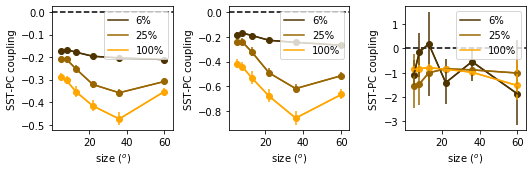

In [248]:
plt.figure(figsize=(7.5,2.5))
usize = [5,8,13,22,36,60]
c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
for ilight in range(3):
    plt.subplot(1,3,ilight+1)
    ut.plot_bootstrapped_errorbars_hillel(usize,couplings[lkat,5*ilight,:,:,1,0][:,:,[1,3,5]].transpose((0,2,1)),pct=(2.5,97.5),colors=c_sst)
    plt.axhline(0,linestyle='dashed',c='k')
    plt.xlabel('size ($^o$)')
    plt.ylabel('SST-PC coupling')
    plt.legend(['6%','25%','100%'])
    plt.tight_layout()
# plt.savefig('figures/sst_sst_coupling_size_by_3_contrasts.eps')

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


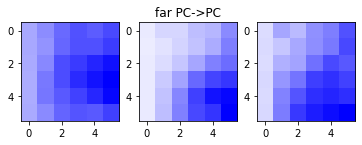

In [100]:
for itype1 in range(8,9):
    for itype2 in range(0,1):
        plt.figure()
        for ilight in range(3):
            plt.subplot(1,3,ilight+1)
            data = np.nanmedian(couplings[:,5*ilight,:,:,itype1,itype2],0)
            mx = np.max(np.abs(data))
            plt.imshow(data,vmin=-mx,vmax=mx,cmap='bwr')
        plt.subplot(1,3,2)
        plt.title('%s->%s'%('far PC',lbls[itype2]))

In [26]:
ucontrast = np.array([0,6,12,25,50,100])

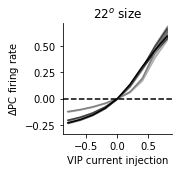

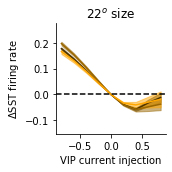

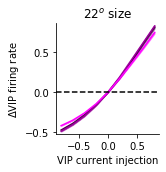

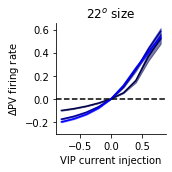

In [96]:
iwt = 0
data = np.zeros((nwt,YY_opto_medium[0].shape[0],6,6))
yoffset = 0.1
opto_range = slice(1,10)
these_opto_levels = opto_levels[opto_range]
for itype in [0,1,2,3]:
    plt.figure(figsize=(2.5,2.5))
    isize = 3
    tlast = 200
    icontrasts = [1,3,5]
    these_colors = colors[itype+1]
    for iwt in range(nwt):
        data[iwt] = np.nanmean(YY_opto_medium[iwt][:,:,-tlast:,itype],2).reshape((-1,6,6)) # light, stim, time, type
        data[iwt] = (data[iwt] - data[iwt,5])#/(data[iwt] + data[iwt,5])
    for iicontrast,icontrast in enumerate(icontrasts):
        this_data = data[:,:,isize,icontrast]
        this_color = these_colors[iicontrast]
        mn = np.mean(this_data,0)[opto_range]
        sem = np.std(this_data,0)[opto_range]/np.sqrt(this_data.shape[0])
        plt.plot(these_opto_levels,mn,c=this_color)
        plt.fill_between(these_opto_levels,mn-sem,mn+sem,alpha=0.5,color=this_color)
        plt.ylim(((mn-sem-yoffset).min(),(mn+sem+yoffset).max()))
#     plt.legend(['%d%% contrast'%uc for uc in ucontrast[icontrasts]])
    plt.title('%d$^o$ size'%usize[isize])
    plt.axhline(0,c='k',linestyle='dashed')
    plt.xlabel('VIP current injection')
    plt.ylabel('$\Delta$%s firing rate'%lbls[itype])
    ut.erase_top_right()
    plt.tight_layout()
    plt.savefig('figures/%s_vip_current_injection.jpg'%lbls[itype],dpi=300)

In [203]:
import calnet.utils
import sim_utils

In [69]:
nfiles = nwt#len(weights_files)
Ts = np.zeros((nfiles,nQ))
Ks = np.zeros((nfiles,nQ))
Wmys = np.zeros((nfiles,nQ,nQ))
Wmxs = np.zeros((nfiles,nP,nQ))
s02s = np.zeros((nfiles,nQ))
YYs = np.zeros((nfiles,6,6,nQ*nS*nT))
XXs = np.zeros((nfiles,6,6,nP*nS*nT))
couplings = np.zeros((nfiles,6,6,nQ*nS*nT,nQ*nS*nT))
Xcouplings = np.zeros((nfiles,6,6,nP*nS*nT,nQ*nS*nT))
for iwt,weights_file in enumerate(weights_files):
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
    Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h = Wstar_dict['as_list']
    WWmy = calnet.utils.gen_Weight_k_kappa_t(Wmy,K,kappa,T)
    WWmx = calnet.utils.gen_Weight_k_kappa_t(Wmx,K,kappa,T)
    tiled_s02 = np.tile(s02,nS*nT)
    Ts[iwt] = T
    Ks[iwt] = K
    Wmys[iwt] = Wmy
    Wmxs[iwt] = Wmx
    s02s[iwt] = s02
    YYs[iwt] = sim_utils.f_miller_troyer(Eta,Xi**2+tiled_s02).reshape((6,6,nQ*nS*nT))
    XXs[iwt] = XX.reshape((6,6,nP*nS*nT))
    for istim in range(nN):
        iistim,jjstim = np.unravel_index(istim,(6,6))
        Phi = np.diag(calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+tiled_s02))
        couplings[iwt,iistim,jjstim] = Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
        Xcouplings[iwt,iistim,jjstim] = WWmx @ Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
# couplings = np.reshape(couplings,(couplings.shape[0],6,6,couplings.shape[2],couplings.shape[3]))
# Xcouplings = np.reshape(Xcouplings,(Xcouplings.shape[0],6,6,Xcouplings.shape[2],Xcouplings.shape[3]))

NameError: name 'nQ' is not defined

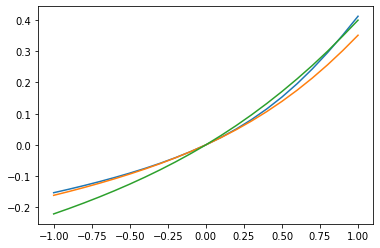

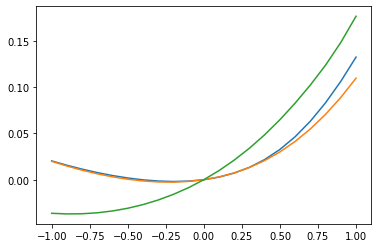

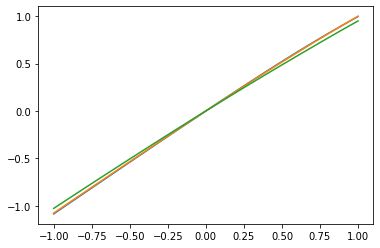

In [277]:
for itype in [0,1,2]:
    plt.figure()
    isize = 5
    tlast = 1000
    data = np.nanmean(YY_opto[:,:,-tlast:,itype],2).reshape((-1,6,6)) # light, stim, time, type
    for icontrast in [1,3,5]:
        plt.plot(opto_levels,data[:,isize,icontrast]-data[10,isize,icontrast])

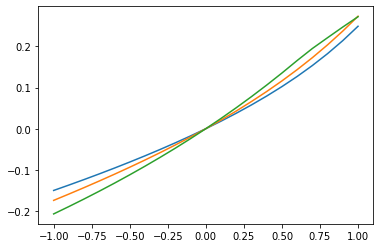

In [191]:
plt.figure()
itype = 0
isize = 2
tlast = 1000
data = np.nanmean(YY_opto[:,:,-tlast:,itype],2).reshape((-1,6,6)) # light, stim, time, type
for icontrast in [1,3,5]:
    plt.plot(opto_levels,data[:,isize,icontrast]-data[10,isize,icontrast])

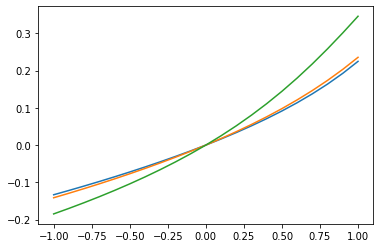

In [193]:
plt.figure()
itype = 0
isize = 5
tlast = 1000
data = np.nanmean(YY_opto[:,:,-tlast:,itype],2).reshape((-1,6,6)) # light, stim, time, type
for icontrast in [1,3,5]:
    plt.plot(opto_levels,data[:,isize,icontrast]-data[10,isize,icontrast])

In [13]:
pdb.pm()


> /Users/dan/Documents/code/adesnal/calnet/dynamics.py(142)predict_YY_current_injection()
-> YY = np.zeros((Niter+1,YY0.shape[1]))
(Pdb) Nfix
*** NameError: name 'Nfix' is not defined
(Pdb) YY0.shape
(16,)
(Pdb) exit


In [215]:
reload(dyn)
YY_fix = dyn.compute_steady_state_Model(mdl,Niter=int(1.5e3),fix_dim=np.arange(mdl.nQ),Ny=25,dt=1e-1)

0


/Users/dan/Documents/code/adesnal/calnet/utils.py:632: RuntimeWarning: overflow encountered in square
  A = 0.5*mu*(1+ssp.erf(u))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


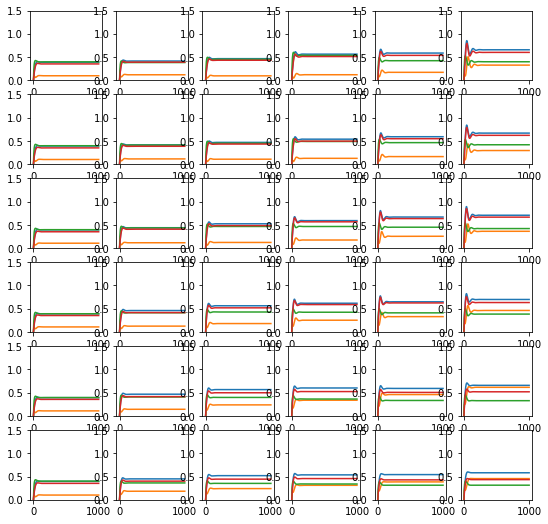

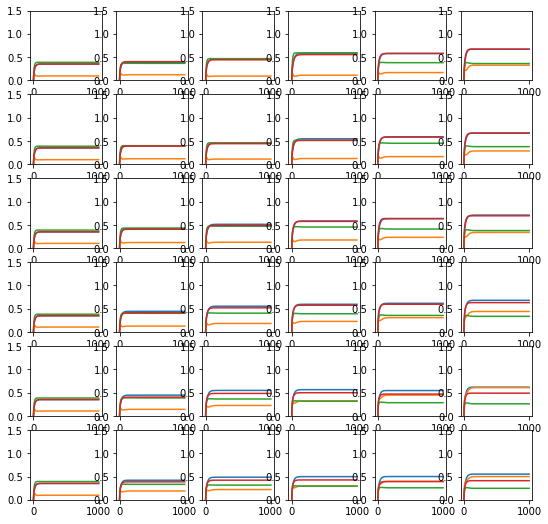

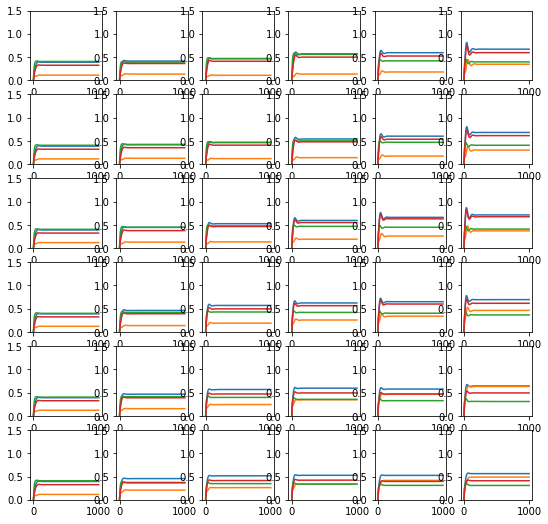

In [50]:
import pyute as ut
# ut.mkdir('figures/dynamics_simulations/200724a/')
for iwt in range(nwt):
    mag = 1.5
    plt.figure(figsize=(6*mag,6*mag))
    for icelltype in range(4):
        for istim in range(36):
            plt.subplot(6,6,istim+1)
            plt.plot(YY_ss[iwt][istim,:,icelltype]) #-YY_ss[imodel][istim,-1,icelltype])
            plt.ylim((0,1.5))
#     plt.savefig('figures/dynamics_simulations/200724a/%d.jpg'%iwt)

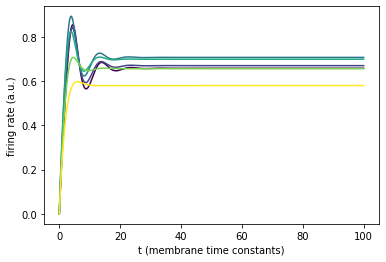

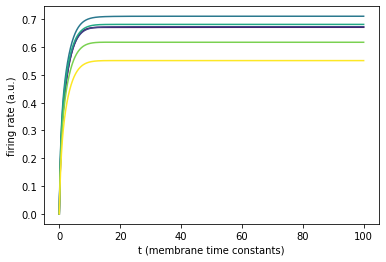

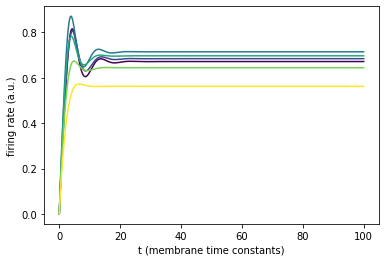

In [51]:
colors = plt.cm.viridis(np.linspace(0,1,6))
ut.mkdir('figures/dynamics_simulations_inset')
for iwt in range(nwt):
    plt.figure()
    tlim = 1001
    t = np.arange(tlim)*dt
    data = YY_ss[iwt].reshape((6,6)+YY_ss[iwt].shape[1:])
    itype = 0
    icontrast = 5
    for isize in np.arange(6):
        plt.plot(t,data[isize,icontrast,:tlim,itype],c=colors[isize])
    plt.xlabel('t (membrane time constants)')
    plt.ylabel('firing rate (a.u.)')
#     plt.savefig('figures/dynamics_simulations_inset/%d.jpg'%iwt)

In [52]:
plt.figure()
for ilight in [0,5,10]:
    plt.plot(YY_opto[0,ilight,-1,:,0])

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x288 with 0 Axes>

TypeError: list indices must be integers or slices, not tuple

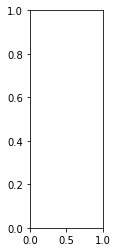

In [53]:
for itype in range(4):
    plt.subplot(1,4,itype+1)
    plt.imshow(YY_ss[:,-1,itype].reshape((6,6)))

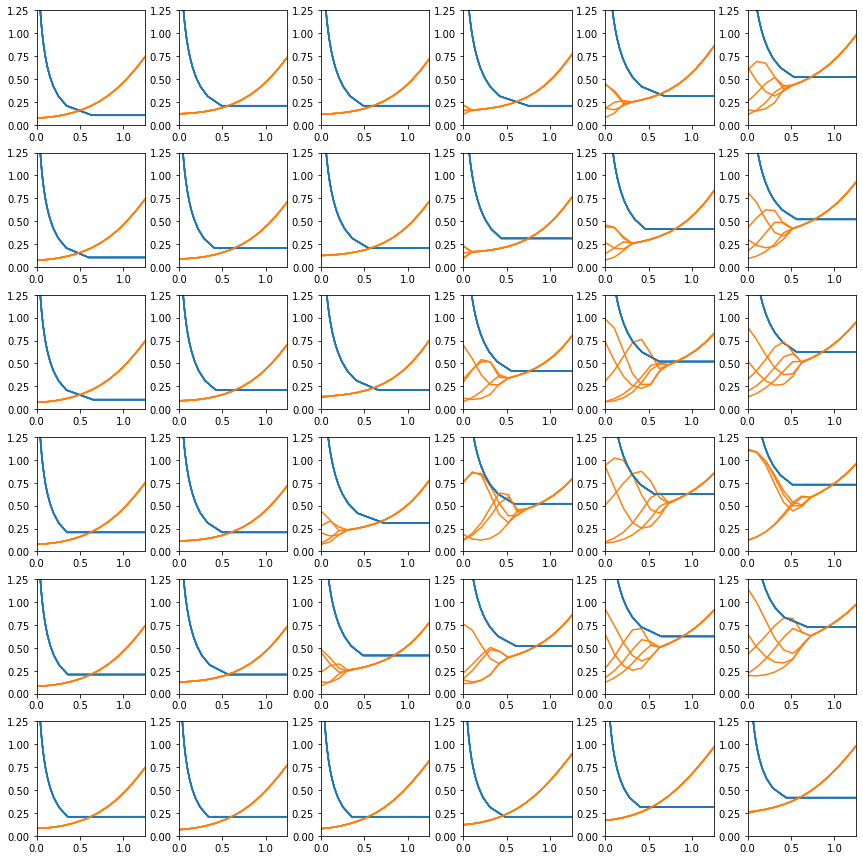

In [220]:
mag = 2
ix = 0
iy = 1
max_val = 2.5
Ny = 25
xvals = np.linspace(0,max_val,Ny)
plt.figure(figsize=(6*mag,6*mag))
for istim in range(YY_fix.shape[1]):
    plt.subplot(6,6,istim+1)
    for it in [-400,-300,-200,-100,-1]:
        plt.plot(YY_fix[iy,istim,:,it,ix],xvals,c='C0')
        plt.plot(xvals,YY_fix[ix,istim,:,it,iy],c='C1')
        plt.xlim((0,1.25))
        plt.ylim((0,1.25))
plt.tight_layout()

In [82]:
def f_basic(mu,sigma=1):
    return utils.f_miller_troyer(mu,sigma)
def run_small_sim(W,h,r0,f=f_basic,Niter=int(1e3),dt=1e-1):
    def drdt(r):
        return -r + f(r @ W + h)
    r = r0
    for t in range(Niter):
        r = r + dt*drdt(r)
    return r
    

In [253]:
# W = np.array(((1,2),(-3,-2)))
W = 2*np.array(((1,1),(-2,-1)))
# hs = [np.array((1,0.99)),np.array((1,1)),np.array((1,1.01))]
hs = [np.array((1,0.49)),np.array((1,0.75)),np.array((1,0.51))]
# h2 = np.array((1,1.25))
r0 = np.array((1,1))
nstim = 100
inputs = np.linspace(-2,2,nstim)
rs = [np.zeros((nstim,2)) for h in hs]
for iinp in range(len(hs)):
    for istim in range(nstim):
        rs[iinp][istim] = run_small_sim(W,hs[iinp]*inputs[istim],r0,f=lambda mu: utils.f_miller_troyer(mu,0.05))
        r0 = rs[iinp][istim].copy()

In [227]:
ww,vv = np.linalg.eig(W.T)

In [228]:
-h2 @ np.linalg.inv(W-1)

array([-0.5 ,  0.25])

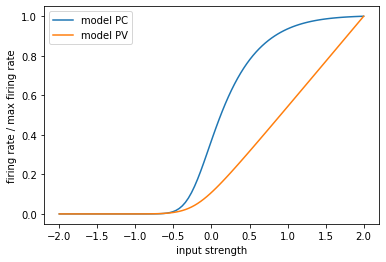

In [255]:
for iinp in (1,): #range(len(hs)):
    plt.figure()
    plt.plot(inputs,rs[iinp]/rs[iinp].max(0)[np.newaxis,:])
    plt.legend(['model PC','model PV'])
    plt.xlabel('input strength')
    plt.ylabel('firing rate / max firing rate')
plt.savefig('figures/toy_model_pc_pv.jpg',dpi=300)

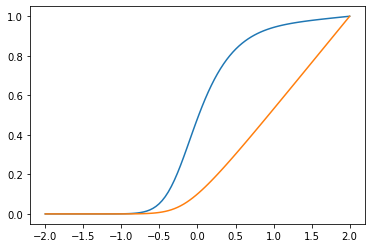

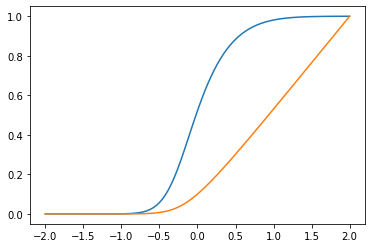

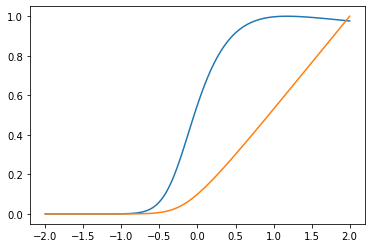

In [238]:
for iinp in range(len(hs)):
    plt.figure()
    plt.plot(inputs,rs[iinp]/rs[iinp].max(0)[np.newaxis,:])
# plt.plot(inputs,r2)

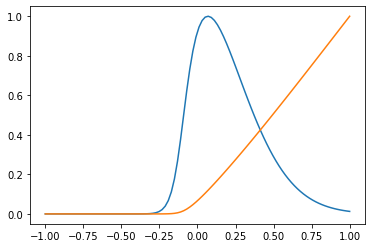

In [220]:
plt.figure()
plt.plot(inputs,r2/r2.max(0)[np.newaxis,:])

(0, 0.04)

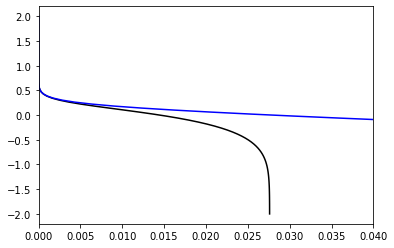

In [234]:
plt.figure()
plt.plot(r[:,0],-inputs,c='k')
plt.plot(r[:,1],-inputs,c='b')
plt.xlim((0,0.04))